In [139]:
import numpy as np
import yfinance as yf
import pandas as pd
# import tulipy as ti
from math import asin, sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
# from termcolor import colored as cl
from math import floor
from fredapi import Fred
# import investpy
import seaborn as sns
import itertools
from qiskit_aer import AerSimulator
from qiskit.providers.basic_provider import BasicProvider
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
# from qiskit_ibm_runtime import SamplerV2 as Sampler
from pgmpy.models import BayesianModel,BayesianNetwork
from pgmpy.base import DAG
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.estimators import BicScore, K2Score#, BdeuScore
from pgmpy.estimators import HillClimbSearch
import networkx as nx
import pylab as plt
import pyfolio as pf

# import warnings
# import logging

In [140]:
### Qiskit Runtime service initialization
QiskitRuntimeService.save_account(channel = 'ibm_quantum',
                                  token = 'afbbd92eae66abcc98ea8bfd6269888a2fbeb2cc875b1f30c6cc67ced46d4b5ef84270be2de6c64361ec83180dd3f6f1c616db0debf34cdf5d7816ba9d374597',
                                  instance='ibm-q/open/main',
                                  overwrite=True)
service = QiskitRuntimeService(verify=False)

/home/aniruddha/miniconda3/envs/capstone_env1/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'auth.quantum-computing.ibm.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/aniruddha/miniconda3/envs/capstone_env1/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'auth.quantum-computing.ibm.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/aniruddha/miniconda3/envs/capstone_env1/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'auth.quantum-computing.ibm.com'. Adding certificate verification is strongly advised. See: https://

In [141]:
######## utility functions ############
#### Utility functions for QBN ######

def prob_to_angle(prob):
    return 2*asin(sqrt(prob))


def bit_str_2_arr(bitstring):
	my_state = bitstring[::-1]
	bit_array = np.zeros(len(my_state))
	for i in range(len(my_state)):
		if int(my_state[i]) == 0:
			pass
		else:
			bit_array[i] = int(my_state[i])
	return bit_array



def custom_mcry(circuit,angle,control_qubits,target,control_state):
	# Multi-coltrolled Ry gate #
	Id = []
	for i in range(len(control_state)):
		c = control_state[i]
		if c == '0':
			Id.append(control_qubits[i])			
		else:
			pass
	if len(Id) == 0:
		pass
	else:
		circuit.x(Id)
	circuit.mcry(angle,control_qubits,target)
	if len(Id) == 0:
		pass
	else:
		circuit.x(Id)
	return circuit

In [165]:
start_date = '2019-01-01'
end_date =   '2019-12-31'

In [166]:
# ^SOX > PHLX semiconductor data
# CNY=X > Yuan to USD forex rate
# EUR=X > EURO to USD forex rate
# ^TNX > CBOE Interest Rate 10 Year T No

target = 'BTC-USD'
tickers = [target,"^VIX","^NDX","^GSPC","^SOX"] #,"CNY=X","EUR=X","^TNX"]

###### Stock Data Collection #######
###### The trading algoorithm will be designed for this Assets #############
data0 = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
data0.head()

[*********************100%%**********************]  5 of 5 completed


Ticker,BTC-USD,^GSPC,^NDX,^SOX,^VIX
Date,,,,,
2019-01-01,3843.520020,NaN,NaN,NaN,NaN
2019-01-02,3943.409424,2510.030029,6360.870117,1165.300049,23.219999
2019-01-03,3836.741211,2447.889893,6147.129883,1096.030029,25.450001
2019-01-04,3857.717529,2531.939941,6422.669922,1143.959961,21.379999
2019-01-05,3845.194580,NaN,NaN,NaN,NaN


In [167]:
# fred = Fred(api_key='8bd22ac3ad2b9cdcbe7c4d5bb66e94ae')

# # 'DCOILWTICO' > West Texas Intermediate (WTI) - Cushing, Oklahoma - crude oil
# # DFF' > Federal fund rate
# series_ids = ['DCOILWTICO'] # ,'DFF']

# data1 = pd.DataFrame()

# # Loop through each series ID and fetch the data
# for series_id in series_ids:
#     df = fred.get_series(series_id)
#     data1[series_id] = df

# # Filter the DataFrame to include data only from 2010 to 2020
# data1 = data1.loc[data0.index]
# data1.head()

In [168]:
##### Joining two dataframes #####
data = data0
# data = pd.concat([data0,data1],axis=1)
# data.head()

In [169]:
####### removing NaN vaalues from the data set ################
data = data.dropna()
print("Number of available samples are",data.shape[0])
print("Number of NaN value on each columns are:\n",data.isna().sum())
data.head()

Number of available samples are 251
Number of NaN value on each columns are:
 Ticker
BTC-USD    0
^GSPC      0
^NDX       0
^SOX       0
^VIX       0
dtype: int64


Ticker,BTC-USD,^GSPC,^NDX,^SOX,^VIX
Date,,,,,
2019-01-02,3943.409424,2510.030029,6360.870117,1165.300049,23.219999
2019-01-03,3836.741211,2447.889893,6147.129883,1096.030029,25.450001
2019-01-04,3857.717529,2531.939941,6422.669922,1143.959961,21.379999
2019-01-07,4025.248291,2549.689941,6488.250000,1166.239990,21.400000
2019-01-08,4030.847900,2574.409912,6551.850098,1160.550049,20.469999


In [170]:
###### Converting to Percentage changes data ##########
data = data.pct_change().dropna()
data.head()

Ticker,BTC-USD,^GSPC,^NDX,^SOX,^VIX
Date,,,,,
2019-01-03,-0.027050,-0.024757,-0.033602,-0.059444,0.096038
2019-01-04,0.005467,0.034336,0.044824,0.043730,-0.159921
2019-01-07,0.043427,0.007010,0.010211,0.019476,0.000935
2019-01-08,0.001391,0.009695,0.009802,-0.004879,-0.043458
2019-01-09,0.001104,0.004098,0.007454,0.025238,-0.023937


In [171]:
transformed_df = data.apply(lambda x: (x + (0.5-data.mean())),axis=1)
transformed_df.head()

Ticker,BTC-USD,^GSPC,^NDX,^SOX,^VIX
Date,,,,,
2019-01-03,0.469553,0.474214,0.465087,0.438580,0.594984
2019-01-04,0.502070,0.533306,0.543513,0.541754,0.339025
2019-01-07,0.540030,0.505981,0.508900,0.517500,0.499882
2019-01-08,0.497994,0.508666,0.508491,0.493145,0.455488
2019-01-09,0.497706,0.503069,0.506143,0.523262,0.475009


In [172]:
####### The Quantum Data ##############
q_data = 2*np.arctan(np.sqrt((transformed_df)/(1-transformed_df)))
q_data.head()

Ticker,BTC-USD,^GSPC,^NDX,^SOX,^VIX
Date,,,,,
2019-01-03,1.509864,1.519201,1.500912,1.447645,1.761927
2019-01-04,1.574936,1.637458,1.657933,1.654402,1.243008
2019-01-07,1.650942,1.582758,1.588596,1.605803,1.570560
2019-01-08,1.566784,1.588129,1.587780,1.557086,1.481655
2019-01-09,1.566209,1.576933,1.583083,1.617336,1.520793


In [174]:
############## Data Discretization with Quantum Measurement ##############

DATA_STATES = []

k = 0
y = 20
 
backend = AerSimulator()

for i in range(k,q_data.shape[0]):
    circ = QuantumCircuit(q_data.shape[1])   
    for j in range(q_data.shape[1]):
        theta = q_data.iloc[i,j]
        # circ.ry(theta,j)
        if theta > np.pi/2:
            theta_prime = np.pi #theta + np.pi/y + (theta - np.pi/2)
            circ.ry(theta_prime,j)
            # circ.ry(np.pi - (theta - np.pi/2),j)

        elif theta < np.pi/2:
            theta_prime = 0 #theta - np.pi/y - (np.pi/2 - theta)
            circ.ry(theta_prime,j)
            # circ.ry((theta - np.pi/2),j)

        else:
            theta_prime = theta
            circ.ry(theta,j)
        print("Theta is {} and Theta_Prime is {}".format(theta,theta_prime))

    circ.measure_all()
    # pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    # isa_circuit = pm.run(circ) 

    with Session(service, backend = backend) as session:
        sampler = Sampler(session=session)

        job = sampler.run(circ, shots=1000)
        result = job.result()
        binary_data = result.quasi_dists[0].binary_probabilities()
        state = max(zip(binary_data.values(), binary_data.keys()))[1]
        DATA_STATES.append(bit_str_2_arr(state))
    print(f"Job result: {state}")

/tmp/ipykernel_14007/3324779740.py:35: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session)
base_primitive._run_primitive:INFO:2024-07-17 12:29:49,161: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25535 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Theta is 1.5098644520715412 and Theta_Prime is 0
Theta is 1.519200990389137 and Theta_Prime is 0
Theta is 1.5009124714689503 and Theta_Prime is 0
Theta is 1.447644832945078 and Theta_Prime is 0
Theta is 1.7619265208387112 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 17.15374 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.13924 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05388 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.92237 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.14877 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.07939 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06437 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.41080 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.04625 (ms)
INFO:qiskit.passmanage

Job result: 10000
Theta is 1.5749360924373248 and Theta_Prime is 3.141592653589793
Theta is 1.6374581301664142 and Theta_Prime is 3.141592653589793
Theta is 1.6579326357002695 and Theta_Prime is 3.141592653589793
Theta is 1.6544021056744806 and Theta_Prime is 3.141592653589793
Theta is 1.243007638630435 and Theta_Prime is 0
Job result: 01111
Theta is 1.6509422709622936 and Theta_Prime is 3.141592653589793
Theta is 1.5827584949204294 and Theta_Prime is 3.141592653589793
Theta is 1.5885964340705765 and Theta_Prime is 3.141592653589793
Theta is 1.605803370625488 and Theta_Prime is 3.141592653589793
Theta is 1.5705599792738048 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25964 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01111
Theta is 1.5667838675614139 and Theta_Prime is 0
Theta is 1.5881287777921862 and Theta_Prime is 3.141592653589793
Theta is 1.587779572495021 and Theta_Prime is 3.141592653589793
Theta is 1.5570855739771694 and Theta_Prime is 0
Theta is 1.4816551029267802 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:29:50,154: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.29087 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 00110
Theta is 1.566208840399646 and Theta_Prime is 0
Theta is 1.5769334693668384 and Theta_Prime is 3.141592653589793
Theta is 1.5830830834583474 and Theta_Prime is 3.141592653589793
Theta is 1.6173364787152618 and Theta_Prime is 3.141592653589793
Theta is 1.5207932762706111 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:29:50,378: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.27084 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01110
Theta is 1.3863299112862868 and Theta_Prime is 0
Theta is 1.5777742341332537 and Theta_Prime is 3.141592653589793
Theta is 1.5743097854667776 and Theta_Prime is 3.141592653589793
Theta is 1.5862756586734308 and Theta_Prime is 3.141592653589793
Theta is 1.520619973761326 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:29:50,625: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.28443 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01110
Theta is 1.5685904300146105 and Theta_Prime is 0
Theta is 1.5684447420892502 and Theta_Prime is 0
Theta is 1.562271455756808 and Theta_Prime is 0
Theta is 1.586221786202036 and Theta_Prime is 3.141592653589793
Theta is 1.4339029508482408 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:29:50,860: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.07153 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03195 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.37885 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01000
Theta is 1.5741372072995397 and Theta_Prime is 3.141592653589793
Theta is 1.558221958241738 and Theta_Prime is 0
Theta is 1.549885543258 and Theta_Prime is 0
Theta is 1.535906109325381 and Theta_Prime is 0
Theta is 1.6655872843105948 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:29:51,097: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01097 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02933 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.20123 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 10001
Theta is 1.5233060256763398 and Theta_Prime is 0
Theta is 1.590181931353912 and Theta_Prime is 3.141592653589793
Theta is 1.6075032924980406 and Theta_Prime is 3.141592653589793
Theta is 1.5714490425675147 and Theta_Prime is 3.141592653589793
Theta is 1.5193743595859122 and Theta_Prime is 0
Job result: 01110
Theta is 1.577404998830035 and Theta_Prime is 3.141592653589793
Theta is 1.5731813131776886 and Theta_Prime is 3.141592653589793
Theta is 1.567850172766384 and Theta_Prime is 0
Theta is 1.5504015064493555 and Theta_Prime is 0
Theta is 1.6160163231644697 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.09441 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03433 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05984 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.99349 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.12469 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08535 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.04816 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01669 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 98.36960 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:29:51,369: Submitting job using options {'optimization_level':

Job result: 10011
Theta is 1.5768920068162444 and Theta_Prime is 3.141592653589793
Theta is 1.5839205174629525 and Theta_Prime is 3.141592653589793
Theta is 1.5831371607018359 and Theta_Prime is 3.141592653589793
Theta is 1.5897057052877805 and Theta_Prime is 3.141592653589793
Theta is 1.4655535337728318 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.15545 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.11611 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05937 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.13654 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.17285 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08655 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06437 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01812 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 208.22859 (ms)
base_primitive._run_primitive:INFO:2024-0

Job result: 01111
Theta is 1.5527328814137604 and Theta_Prime is 0
Theta is 1.595105840262025 and Theta_Prime is 3.141592653589793
Theta is 1.5878698050202413 and Theta_Prime is 3.141592653589793
Theta is 1.612776914158507 and Theta_Prime is 3.141592653589793
Theta is 1.539891170780221 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:29:51,927: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.65446 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01110
Theta is 1.5348716854105442 and Theta_Prime is 0
Theta is 1.5404180554494162 and Theta_Prime is 0
Theta is 1.5275392763627478 and Theta_Prime is 0
Theta is 1.5098670151286777 and Theta_Prime is 0
Theta is 1.912371169542221 and Theta_Prime is 3.141592653589793
Job result: 10000
Theta is 1.5532066180937798 and Theta_Prime is 0
Theta is 1.5731431676431404 and Theta_Prime is 3.141592653589793
Theta is 1.571769677799743 and Theta_Prime is 3.141592653589793
Theta is 1.554424251707075 and Theta_Prime is 0
Theta is 1.4452829300144316 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.28706 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 00110
Theta is 1.5727837238858486 and Theta_Prime is 3.141592653589793
Theta is 1.5714887911044935 and Theta_Prime is 3.141592653589793
Theta is 1.5813268618117977 and Theta_Prime is 3.141592653589793
Theta is 1.681679523870003 and Theta_Prime is 3.141592653589793
Theta is 1.504090281467986 and Theta_Prime is 0
Job result: 01111
Theta is 1.5633908204055162 and Theta_Prime is 0
Theta is 1.5857152814872715 and Theta_Prime is 3.141592653589793
Theta is 1.5934858669269858 and Theta_Prime is 3.141592653589793
Theta is 1.610318088554109 and Theta_Prime is 3.141592653589793
Theta is 1.412389547846428 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25153 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01110
Theta is 1.4920737720951636 and Theta_Prime is 0
Theta is 1.553042752344151 and Theta_Prime is 0
Theta is 1.5415674631102774 and Theta_Prime is 0
Theta is 1.525053150787765 and Theta_Prime is 0
Theta is 1.7359136957893428 and Theta_Prime is 3.141592653589793
Job result: 10000
Theta is 1.551129706315842 and Theta_Prime is 0
Theta is 1.5658248263062484 and Theta_Prime is 0
Theta is 1.5489700109794466 and Theta_Prime is 0
Theta is 1.5378996482276273 and Theta_Prime is 0
Theta is 1.596248566575275 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.28014 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.5860807723995676 and Theta_Prime is 3.141592653589793
Theta is 1.5998399448100118 and Theta_Prime is 3.141592653589793
Theta is 1.6209995018907075 and Theta_Prime is 3.141592653589793
Theta is 1.624317248462388 and Theta_Prime is 3.141592653589793
Theta is 1.4143665835944357 and Theta_Prime is 0
Job result: 01111
Theta is 1.5477130468243758 and Theta_Prime is 0
Theta is 1.5859327098142708 and Theta_Prime is 3.141592653589793
Theta is 1.5972402968253863 and Theta_Prime is 3.141592653589793
Theta is 1.567362647423308 and Theta_Prime is 0
Theta is 1.4449140025917886 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02670 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.16046 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.09441 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06390 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.74935 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.14091 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.09322 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05412 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.compiler.transpiler:Tot

Job result: 00110
Theta is 1.58144220392904 and Theta_Prime is 3.141592653589793
Theta is 1.5705345601237244 and Theta_Prime is 0
Theta is 1.5591045698724877 and Theta_Prime is 0
Theta is 1.5909158314939016 and Theta_Prime is 3.141592653589793
Theta is 1.5167616745326538 and Theta_Prime is 0
Job result: 01001
Theta is 1.5474905169112674 and Theta_Prime is 0
Theta is 1.5822900662389754 and Theta_Prime is 3.141592653589793
Theta is 1.592738305333121 and Theta_Prime is 3.141592653589793
Theta is 1.576910566308917 and Theta_Prime is 3.141592653589793
Theta is 1.517858872057225 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 8.06880 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.80585 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.28038 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01110
Theta is 1.568166447790225 and Theta_Prime is 0
Theta is 1.578154247085926 and Theta_Prime is 3.141592653589793
Theta is 1.5864391836908078 and Theta_Prime is 3.141592653589793
Theta is 1.576504653401051 and Theta_Prime is 3.141592653589793
Theta is 1.5483438683476967 and Theta_Prime is 0


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.001s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 20.43319 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 8.05831 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05221 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.44053 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.11826 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.11349 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06771 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoi

Job result: 01110
Theta is 1.5336502330241255 and Theta_Prime is 0
Theta is 1.5642884180418526 and Theta_Prime is 0
Theta is 1.5607986980275135 and Theta_Prime is 0
Theta is 1.6185952522199338 and Theta_Prime is 3.141592653589793
Theta is 1.544280066406281 and Theta_Prime is 0
Job result: 01000
Theta is 1.5556254735262889 and Theta_Prime is 0
Theta is 1.5500215653191023 and Theta_Prime is 0
Theta is 1.5416923350283382 and Theta_Prime is 0
Theta is 1.5220788589882186 and Theta_Prime is 0
Theta is 1.697768642915076 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.24724 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.7218400912025975 and Theta_Prime is 3.141592653589793
Theta is 1.5700897420555433 and Theta_Prime is 0
Theta is 1.5705346428194722 and Theta_Prime is 0
Theta is 1.5645429621156282 and Theta_Prime is 0
Theta is 1.4891848372522722 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.11635 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08440 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.04554 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01478 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 193.50362 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:29:54,826: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Job result: 00001
Theta is 1.553992276789276 and Theta_Prime is 0
Theta is 1.5701555460938388 and Theta_Prime is 0
Theta is 1.5670313788592591 and Theta_Prime is 0
Theta is 1.576763727624591 and Theta_Prime is 3.141592653589793
Theta is 1.6005000120049582 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.21648 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 11000
Theta is 1.5667961963101222 and Theta_Prime is 0
Theta is 1.594520014700533 and Theta_Prime is 3.141592653589793
Theta is 1.5987137931928568 and Theta_Prime is 3.141592653589793
Theta is 1.6093934746563412 and Theta_Prime is 3.141592653589793
Theta is 1.501005592948766 and Theta_Prime is 0
Job result: 01110
Theta is 1.5522541160202832 and Theta_Prime is 0
Theta is 1.5747853398569516 and Theta_Prime is 3.141592653589793
Theta is 1.5685190341898918 and Theta_Prime is 0
Theta is 1.5728135809440413 and Theta_Prime is 3.141592653589793
Theta is 1.5972078881324496 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.23723 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_mat

Job result: 11010
Theta is 1.5556368464796622 and Theta_Prime is 0
Theta is 1.5634339903190584 and Theta_Prime is 0
Theta is 1.5700384091387578 and Theta_Prime is 0
Theta is 1.571915733737294 and Theta_Prime is 3.141592653589793
Theta is 1.6415915646449184 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03028 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.14782 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.09370 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06938 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.67663 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.10824 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.09775 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.04840 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02217 (ms)
INFO:qiskit.compiler.transpiler:Tot

Job result: 11000
Theta is 1.566174724295751 and Theta_Prime is 0
Theta is 1.5904961193214504 and Theta_Prime is 3.141592653589793
Theta is 1.577504295700417 and Theta_Prime is 3.141592653589793
Theta is 1.577363878809317 and Theta_Prime is 3.141592653589793
Theta is 1.4064208930640123 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 27.96531 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.13065 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05579 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.52206 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.13804 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.10920 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05460 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.96941 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02027 (ms)
INFO:qiskit.passmanage

Job result: 01110
Theta is 1.7451099213764567 and Theta_Prime is 3.141592653589793
Theta is 1.5717348267210929 and Theta_Prime is 3.141592653589793
Theta is 1.5714141398494361 and Theta_Prime is 3.141592653589793
Theta is 1.562861875509612 and Theta_Prime is 0
Theta is 1.5646648814810085 and Theta_Prime is 0


INFO:qiskit.compiler.transpiler:Total Transpile Time - 187.53695 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:29:57,131: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.10085 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.27299 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sx

Job result: 00111
Theta is 1.5907193516616507 and Theta_Prime is 3.141592653589793
Theta is 1.5722915620051199 and Theta_Prime is 3.141592653589793
Theta is 1.5669655408318446 and Theta_Prime is 0
Theta is 1.5843304540131418 and Theta_Prime is 3.141592653589793
Theta is 1.4528242240420743 and Theta_Prime is 0
Job result: 01011
Theta is 1.5411450692095094 and Theta_Prime is 0
Theta is 1.5616843402670664 and Theta_Prime is 0
Theta is 1.560476795649625 and Theta_Prime is 0
Theta is 1.5520956608592995 and Theta_Prime is 0
Theta is 1.631493705180219 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.27704 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.590005300701347 and Theta_Prime is 3.141592653589793
Theta is 1.5815597525554017 and Theta_Prime is 3.141592653589793
Theta is 1.5839437208495195 and Theta_Prime is 3.141592653589793
Theta is 1.5883666452435887 and Theta_Prime is 3.141592653589793
Theta is 1.4368923008932803 and Theta_Prime is 0
Job result: 01111
Theta is 1.502618406092339 and Theta_Prime is 0
Theta is 1.5712010650912989 and Theta_Prime is 3.141592653589793
Theta is 1.5751692998142957 and Theta_Prime is 3.141592653589793
Theta is 1.5832129002302764 and Theta_Prime is 3.141592653589793
Theta is 1.768342986027812 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02766 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01359 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.29540 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 11110
Theta is 1.5494027355983375 and Theta_Prime is 0
Theta is 1.5671564177091435 and Theta_Prime is 0
Theta is 1.570363674576775 and Theta_Prime is 0
Theta is 1.553223178644834 and Theta_Prime is 0
Theta is 1.6117981172528746 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:29:58,080: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01311 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.26298 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 10000
Theta is 1.562283712383135 and Theta_Prime is 0
Theta is 1.5676492359700755 and Theta_Prime is 0
Theta is 1.5664275806366956 and Theta_Prime is 0
Theta is 1.54238478224786 and Theta_Prime is 0
Theta is 1.50668067174137 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02599 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.07248 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.11301 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08082 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05126 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01574 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 226.36414 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:29:58,361: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': Tru

Job result: 00000
Theta is 1.5659429256475006 and Theta_Prime is 0
Theta is 1.5630862469221816 and Theta_Prime is 0
Theta is 1.562702500772097 and Theta_Prime is 0
Theta is 1.5673326213785095 and Theta_Prime is 0
Theta is 1.5795734851895016 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:29:58,636: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02575 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01168 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.27132 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 10000
Theta is 1.566491171722905 and Theta_Prime is 0
Theta is 1.582528250251911 and Theta_Prime is 3.141592653589793
Theta is 1.5834022341212852 and Theta_Prime is 3.141592653589793
Theta is 1.5859971411984852 and Theta_Prime is 3.141592653589793
Theta is 1.4041844694023662 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:29:58,845: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02480 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.31662 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01110
Theta is 1.5131732837354805 and Theta_Prime is 0
Theta is 1.560976065115847 and Theta_Prime is 0
Theta is 1.5679671756717901 and Theta_Prime is 0
Theta is 1.5670198066787353 and Theta_Prime is 0
Theta is 1.725532812542488 and Theta_Prime is 3.141592653589793
Job result: 10000
Theta is 1.6357292028360284 and Theta_Prime is 3.141592653589793
Theta is 1.5664742608380113 and Theta_Prime is 0
Theta is 1.5698409842826773 and Theta_Prime is 0
Theta is 1.5575274310416984 and Theta_Prime is 0
Theta is 1.583726936255463 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03242 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.32997 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10001
Theta is 1.5678860761291462 and Theta_Prime is 0
Theta is 1.5556885679296295 and Theta_Prime is 0
Theta is 1.5557881008213126 and Theta_Prime is 0
Theta is 1.5328157931348199 and Theta_Prime is 0
Theta is 1.7047747050652846 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:29:59,543: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.22960 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 10000
Theta is 1.5678652883778565 and Theta_Prime is 0
Theta is 1.5524848815080607 and Theta_Prime is 0
Theta is 1.5441032052395804 and Theta_Prime is 0
Theta is 1.5447539039747993 and Theta_Prime is 0
Theta is 1.676893096441107 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.44346 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.10824 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08035 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05555 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01836 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 242.66887 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:29:59,869: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': Tru

Job result: 10000
Theta is 1.5587078092747826 and Theta_Prime is 0
Theta is 1.5644739201222835 and Theta_Prime is 0
Theta is 1.564989127201267 and Theta_Prime is 0
Theta is 1.5655094722155065 and Theta_Prime is 0
Theta is 1.5035387656940717 and Theta_Prime is 0
Job result: 00000
Theta is 1.5661013694428232 and Theta_Prime is 0
Theta is 1.5980728058622111 and Theta_Prime is 3.141592653589793
Theta is 1.610469706010903 and Theta_Prime is 3.141592653589793
Theta is 1.6149081371954992 and Theta_Prime is 3.141592653589793
Theta is 1.3526323965056997 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.24056 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01110
Theta is 1.5660137689353062 and Theta_Prime is 0
Theta is 1.5746439858434254 and Theta_Prime is 3.141592653589793
Theta is 1.5785760500369386 and Theta_Prime is 3.141592653589793
Theta is 1.5746074052354302 and Theta_Prime is 3.141592653589793
Theta is 1.4904449572619363 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:00,430: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.30971 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01110
Theta is 1.562753727036355 and Theta_Prime is 0
Theta is 1.582636784231152 and Theta_Prime is 3.141592653589793
Theta is 1.5836439362455363 and Theta_Prime is 3.141592653589793
Theta is 1.5751825524763612 and Theta_Prime is 3.141592653589793
Theta is 1.5163745005185927 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08368 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.04506 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.07033 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01788 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 213.15503 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:00,709: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.0217

Job result: 01110
Theta is 1.5730383062272657 and Theta_Prime is 3.141592653589793
Theta is 1.567001286066821 and Theta_Prime is 0
Theta is 1.5643238651976044 and Theta_Prime is 0
Theta is 1.555511400371826 and Theta_Prime is 0
Theta is 1.582112112183331 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.11182 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.12445 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.04959 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.11611 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.45912 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.13375 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08202 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06342 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01740 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 211.69233 (ms)
base_primitive._run_primitive:INFO:2024-0

Job result: 10001
Theta is 1.582625027873667 and Theta_Prime is 3.141592653589793
Theta is 1.5787072282545322 and Theta_Prime is 3.141592653589793
Theta is 1.5858414418970677 and Theta_Prime is 3.141592653589793
Theta is 1.624960677441037 and Theta_Prime is 3.141592653589793
Theta is 1.4766983917635532 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:01,233: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03576 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.27704 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01111
Theta is 1.6001572284426266 and Theta_Prime is 3.141592653589793
Theta is 1.5761492593066393 and Theta_Prime is 3.141592653589793
Theta is 1.5734538118568542 and Theta_Prime is 3.141592653589793
Theta is 1.5616869681561403 and Theta_Prime is 0
Theta is 1.6028560525223912 and Theta_Prime is 3.141592653589793
Job result: 10111
Theta is 1.5831874656873328 and Theta_Prime is 3.141592653589793
Theta is 1.568476214746881 and Theta_Prime is 0
Theta is 1.5744528306455905 and Theta_Prime is 3.141592653589793
Theta is 1.59360316133714 and Theta_Prime is 3.141592653589793
Theta is 1.6389708379717804 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.09584 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.08225 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.32823 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.43654 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.06700 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05126 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 82.28469 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:01,481: Submitting job using options {'optimization_level':

Job result: 11101
Theta is 1.5720023096918325 and Theta_Prime is 3.141592653589793
Theta is 1.562848549058689 and Theta_Prime is 0
Theta is 1.5767382539296952 and Theta_Prime is 3.141592653589793
Theta is 1.5464626783249265 and Theta_Prime is 0
Theta is 1.6203316172197255 and Theta_Prime is 3.141592653589793
Job result: 10101
Theta is 1.535541855445896 and Theta_Prime is 0
Theta is 1.5904435660342053 and Theta_Prime is 3.141592653589793
Theta is 1.598667796017263 and Theta_Prime is 3.141592653589793
Theta is 1.6369848175393678 and Theta_Prime is 3.141592653589793
Theta is 1.5284175763886687 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.14687 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08702 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05317 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01764 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 92.10443 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:01,757: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
I

Job result: 01110
Theta is 1.5613416742861022 and Theta_Prime is 0
Theta is 1.5307776567070455 and Theta_Prime is 0
Theta is 1.5235270848358435 and Theta_Prime is 0
Theta is 1.5092947988589052 and Theta_Prime is 0
Theta is 1.9999350452281532 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.15450 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08559 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05078 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02289 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 187.41679 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:02,020: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01335 (ms)


Job result: 10000
Theta is 1.53372565753981 and Theta_Prime is 0
Theta is 1.567059289925251 and Theta_Prime is 0
Theta is 1.565689725036686 and Theta_Prime is 0
Theta is 1.5416748705017453 and Theta_Prime is 0
Theta is 1.5504837944920558 and Theta_Prime is 0
Job result: 00000
Theta is 1.5751093257678899 and Theta_Prime is 3.141592653589793
Theta is 1.5831031023200033 and Theta_Prime is 3.141592653589793
Theta is 1.5775195019012949 and Theta_Prime is 3.141592653589793
Theta is 1.587093981713872 and Theta_Prime is 3.141592653589793
Theta is 1.3651608292683561 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01144 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.27442 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01111
Theta is 1.615199805578998 and Theta_Prime is 3.141592653589793
Theta is 1.5594484466078964 and Theta_Prime is 0
Theta is 1.5564856108334377 and Theta_Prime is 0
Theta is 1.5378132282881638 and Theta_Prime is 0
Theta is 1.6327612780544514 and Theta_Prime is 3.141592653589793
Job result: 10001
Theta is 1.55521280123275 and Theta_Prime is 0
Theta is 1.5759163253687816 and Theta_Prime is 3.141592653589793
Theta is 1.5715347441635248 and Theta_Prime is 3.141592653589793
Theta is 1.5629497857266077 and Theta_Prime is 0
Theta is 1.4734861087297746 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:02,527: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25821 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 00110
Theta is 1.5783868461710042 and Theta_Prime is 3.141592653589793
Theta is 1.582206147536244 and Theta_Prime is 3.141592653589793
Theta is 1.5841023338684486 and Theta_Prime is 3.141592653589793
Theta is 1.5984529900689426 and Theta_Prime is 3.141592653589793
Theta is 1.4687197198199466 and Theta_Prime is 0
Job result: 01111
Theta is 1.5931900020392484 and Theta_Prime is 3.141592653589793
Theta is 1.591876101311479 and Theta_Prime is 3.141592653589793
Theta is 1.5951863692718318 and Theta_Prime is 3.141592653589793
Theta is 1.6166336964058503 and Theta_Prime is 3.141592653589793
Theta is 1.523448814026299 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03242 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.29778 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01111
Theta is 1.9180594510606515 and Theta_Prime is 3.141592653589793
Theta is 1.568772249972772 and Theta_Prime is 0
Theta is 1.5738491137876935 and Theta_Prime is 3.141592653589793
Theta is 1.5687875063111776 and Theta_Prime is 0
Theta is 1.5627187974225898 and Theta_Prime is 0
Job result: 00101
Theta is 1.6021815306939637 and Theta_Prime is 3.141592653589793
Theta is 1.5730340955715194 and Theta_Prime is 3.141592653589793
Theta is 1.5802627982625987 and Theta_Prime is 3.141592653589793
Theta is 1.6123422325422023 and Theta_Prime is 3.141592653589793
Theta is 1.6256027083574995 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 9.05180 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.10562 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.03958 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 2.28071 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03076 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.18263 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.09966 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.07200 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01335 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 70.08553 (ms)
base_primitive._run_primitive:INFO:2024

Job result: 11111
Theta is 1.5438001168170994 and Theta_Prime is 0
Theta is 1.5729066116660755 and Theta_Prime is 3.141592653589793
Theta is 1.5670076034735492 and Theta_Prime is 0
Theta is 1.5691659598624454 and Theta_Prime is 0
Theta is 1.5453966546190507 and Theta_Prime is 0
Job result: 00010
Theta is 1.6102792006153641 and Theta_Prime is 3.141592653589793
Theta is 1.578010268050803 and Theta_Prime is 3.141592653589793
Theta is 1.5783245588295134 and Theta_Prime is 3.141592653589793
Theta is 1.5828889254405059 and Theta_Prime is 3.141592653589793
Theta is 1.4565110670057069 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.15020 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.09179 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.48590 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05436 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01717 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 98.02985 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:03,457: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01693 (ms)
I

Job result: 01111
Theta is 1.6646379631184163 and Theta_Prime is 3.141592653589793
Theta is 1.570832259848275 and Theta_Prime is 3.141592653589793
Theta is 1.5736895191542575 and Theta_Prime is 3.141592653589793
Theta is 1.571892287971919 and Theta_Prime is 3.141592653589793
Theta is 1.624877731047621 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:03,682: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02909 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.38624 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 11111
Theta is 1.531925241762717 and Theta_Prime is 0
Theta is 1.5566018745019696 and Theta_Prime is 0
Theta is 1.5599498780348324 and Theta_Prime is 0
Theta is 1.5440780392878606 and Theta_Prime is 0
Theta is 1.7363639177260997 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:03,905: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01168 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02742 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25153 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 10000
Theta is 1.6099652390969086 and Theta_Prime is 3.141592653589793
Theta is 1.5756931026378458 and Theta_Prime is 3.141592653589793
Theta is 1.5795370676143552 and Theta_Prime is 3.141592653589793
Theta is 1.5841057985399756 and Theta_Prime is 3.141592653589793
Theta is 1.430979089037189 and Theta_Prime is 0
Job result: 01111
Theta is 1.4661257836465822 and Theta_Prime is 0
Theta is 1.5688135847753286 and Theta_Prime is 0
Theta is 1.5638121470440836 and Theta_Prime is 0
Theta is 1.5653678068911325 and Theta_Prime is 0
Theta is 1.5265693898582515 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.15020 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.04840 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01359 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 74.75209 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:04,128: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01144 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02003

Job result: 00000
Theta is 1.573894553699722 and Theta_Prime is 3.141592653589793
Theta is 1.5819562200043544 and Theta_Prime is 3.141592653589793
Theta is 1.5769325531721006 and Theta_Prime is 3.141592653589793
Theta is 1.595367979728877 and Theta_Prime is 3.141592653589793
Theta is 1.4128876414393745 and Theta_Prime is 0
Job result: 01111
Theta is 1.5551865827777231 and Theta_Prime is 0
Theta is 1.5674785956369006 and Theta_Prime is 0
Theta is 1.5684284312945884 and Theta_Prime is 0
Theta is 1.5517468897550877 and Theta_Prime is 0
Theta is 1.6203328428791008 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.09036 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05054 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.42272 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.11277 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08321 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05198 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.04911 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02170 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 89.21909 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:04,404: Submitting job using options {'optimization_level':

Job result: 10000
Theta is 1.6305252301978077 and Theta_Prime is 3.141592653589793
Theta is 1.5697560557605914 and Theta_Prime is 0
Theta is 1.574887780903222 and Theta_Prime is 3.141592653589793
Theta is 1.6306827345810764 and Theta_Prime is 3.141592653589793
Theta is 1.5459593012939497 and Theta_Prime is 0
Job result: 01101
Theta is 1.5702582418152806 and Theta_Prime is 0
Theta is 1.564189668308715 and Theta_Prime is 0
Theta is 1.5749647019606945 and Theta_Prime is 3.141592653589793
Theta is 1.5979711230340667 and Theta_Prime is 3.141592653589793
Theta is 1.6377044671292271 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.24843 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 11100
Theta is 1.5816897039395976 and Theta_Prime is 3.141592653589793
Theta is 1.5718955247207942 and Theta_Prime is 3.141592653589793
Theta is 1.5705175862341034 and Theta_Prime is 0
Theta is 1.5681924955499773 and Theta_Prime is 0
Theta is 1.4876408127817586 and Theta_Prime is 0
Job result: 00011
Theta is 1.6021238376465121 and Theta_Prime is 3.141592653589793
Theta is 1.5707613750633618 and Theta_Prime is 0
Theta is 1.5743563481550347 and Theta_Prime is 3.141592653589793
Theta is 1.5670491669354425 and Theta_Prime is 0
Theta is 1.62330371043917 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03028 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03099 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01240 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1.40285 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10101
Theta is 1.628113535502411 and Theta_Prime is 3.141592653589793
Theta is 1.5864203871776708 and Theta_Prime is 3.141592653589793
Theta is 1.593383690254693 and Theta_Prime is 3.141592653589793
Theta is 1.587071788433167 and Theta_Prime is 3.141592653589793
Theta is 1.5461421929339865 and Theta_Prime is 0


INFO:qiskit.compiler.transpiler:Total Transpile Time - 194.34524 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:05,351: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.28467 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sx

Job result: 01111
Theta is 1.525404349084775 and Theta_Prime is 0
Theta is 1.564353769022993 and Theta_Prime is 0
Theta is 1.5614396264884614 and Theta_Prime is 0
Theta is 1.5858652867054617 and Theta_Prime is 3.141592653589793
Theta is 1.7091956807333777 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:05,563: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.24319 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 11000
Theta is 1.4707488941860751 and Theta_Prime is 0
Theta is 1.5679993889882602 and Theta_Prime is 0
Theta is 1.5765266188965001 and Theta_Prime is 3.141592653589793
Theta is 1.5307100373596847 and Theta_Prime is 0
Theta is 1.5854322689885478 and Theta_Prime is 3.141592653589793
Job result: 10100
Theta is 1.590423512749473 and Theta_Prime is 3.141592653589793
Theta is 1.5781079893691918 and Theta_Prime is 3.141592653589793
Theta is 1.5706712682111015 and Theta_Prime is 0
Theta is 1.5502817126178463 and Theta_Prime is 0
Theta is 1.4901108767280784 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02813 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25845 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 00011
Theta is 1.5518794631951363 and Theta_Prime is 0
Theta is 1.5708803842892358 and Theta_Prime is 3.141592653589793
Theta is 1.571332448355452 and Theta_Prime is 3.141592653589793
Theta is 1.5630177995114205 and Theta_Prime is 0
Theta is 1.6284224301775012 and Theta_Prime is 3.141592653589793
Job result: 10110
Theta is 1.6034078646633365 and Theta_Prime is 3.141592653589793
Theta is 1.570640173957964 and Theta_Prime is 0
Theta is 1.5534825967979788 and Theta_Prime is 0
Theta is 1.582047062246103 and Theta_Prime is 3.141592653589793
Theta is 1.5702146169280577 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.20957 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01001
Theta is 1.5834276333559254 and Theta_Prime is 3.141592653589793
Theta is 1.5537321856528985 and Theta_Prime is 0
Theta is 1.5605635155106259 and Theta_Prime is 0
Theta is 1.5505202552855812 and Theta_Prime is 0
Theta is 1.8275999650405361 and Theta_Prime is 3.141592653589793
Job result: 10001
Theta is 1.6019826941098072 and Theta_Prime is 3.141592653589793
Theta is 1.5644893265433866 and Theta_Prime is 0
Theta is 1.5610039881459634 and Theta_Prime is 0
Theta is 1.5890413709805267 and Theta_Prime is 3.141592653589793
Theta is 1.5173121674171166 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01335 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.27966 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01001
Theta is 1.6596652710816284 and Theta_Prime is 3.141592653589793
Theta is 1.5880147494917816 and Theta_Prime is 3.141592653589793
Theta is 1.5996822095494299 and Theta_Prime is 3.141592653589793
Theta is 1.5797746755299715 and Theta_Prime is 3.141592653589793
Theta is 1.3519675102945208 and Theta_Prime is 0
Job result: 01111
Theta is 1.5565526989807275 and Theta_Prime is 0
Theta is 1.5597951411791855 and Theta_Prime is 0
Theta is 1.555009517031741 and Theta_Prime is 0
Theta is 1.5324930518587114 and Theta_Prime is 0
Theta is 1.979337580448834 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.44179 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.12732 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08440 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05245 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01836 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 131.30808 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:06,923: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': Tru

Job result: 10000
Theta is 1.5927826345407605 and Theta_Prime is 3.141592653589793
Theta is 1.535706836812658 and Theta_Prime is 0
Theta is 1.5286598775950238 and Theta_Prime is 0
Theta is 1.5183526515296493 and Theta_Prime is 0
Theta is 2.0949533795469266 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:07,175: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.31376 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 10001
Theta is 1.6164940859956796 and Theta_Prime is 3.141592653589793
Theta is 1.5655264649219751 and Theta_Prime is 0
Theta is 1.5622578124057975 and Theta_Prime is 0
Theta is 1.551122101803587 and Theta_Prime is 0
Theta is 1.5769706339521492 and Theta_Prime is 3.141592653589793
Job result: 10001
Theta is 1.6282447310130255 and Theta_Prime is 3.141592653589793
Theta is 1.5626944014190467 and Theta_Prime is 0
Theta is 1.5590370400910214 and Theta_Prime is 0
Theta is 1.5431799347867734 and Theta_Prime is 0
Theta is 1.5377552604243465 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.30375 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_mat

Job result: 00001
Theta is 1.6302182681857296 and Theta_Prime is 3.141592653589793
Theta is 1.5761779604370925 and Theta_Prime is 3.141592653589793
Theta is 1.5691709983963942 and Theta_Prime is 0
Theta is 1.5696470429692904 and Theta_Prime is 0
Theta is 1.2423993512898184 and Theta_Prime is 0
Job result: 00011
Theta is 2.0302560589162013 and Theta_Prime is 3.141592653589793
Theta is 1.5204549652818138 and Theta_Prime is 0
Theta is 1.4989370161329727 and Theta_Prime is 0
Theta is 1.4721249810329409 and Theta_Prime is 0
Theta is 2.1654677338194754 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02599 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.31185 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10001
Theta is 1.609949687584438 and Theta_Prime is 3.141592653589793
Theta is 1.5847696837495386 and Theta_Prime is 3.141592653589793
Theta is 1.5894063211348293 and Theta_Prime is 3.141592653589793
Theta is 1.6149506630868085 and Theta_Prime is 3.141592653589793
Theta is 1.323851049326486 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:08,062: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.11325 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.54622 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01111
Theta is 1.616742589615186 and Theta_Prime is 3.141592653589793
Theta is 1.5804154384274427 and Theta_Prime is 3.141592653589793
Theta is 1.5955669598452322 and Theta_Prime is 3.141592653589793
Theta is 1.5830206652384196 and Theta_Prime is 3.141592653589793
Theta is 1.3882754220399574 and Theta_Prime is 0
Job result: 01111
Theta is 1.4858367625526632 and Theta_Prime is 0
Theta is 1.586528563136894 and Theta_Prime is 3.141592653589793
Theta is 1.588670162922805 and Theta_Prime is 3.141592653589793
Theta is 1.5332976517455172 and Theta_Prime is 0
Theta is 1.4283045872319475 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01121 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01144 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.20432 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 00110
Theta is 1.426271411435044 and Theta_Prime is 0
Theta is 1.5570622414774393 and Theta_Prime is 0
Theta is 1.5479983219798947 and Theta_Prime is 0
Theta is 1.5275326195801258 and Theta_Prime is 0
Theta is 1.656432650678949 and Theta_Prime is 3.141592653589793
Job result: 10000
Theta is 1.7375463646359033 and Theta_Prime is 3.141592653589793
Theta is 1.555237956433236 and Theta_Prime is 0
Theta is 1.5343212477601507 and Theta_Prime is 0
Theta is 1.486244260305506 and Theta_Prime is 0
Theta is 1.6125607466266723 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.06175 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.24319 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.31137 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10001
Theta is 1.5602458956531164 and Theta_Prime is 0
Theta is 1.585729566137938 and Theta_Prime is 3.141592653589793
Theta is 1.5883248369465317 and Theta_Prime is 3.141592653589793
Theta is 1.609407499330739 and Theta_Prime is 3.141592653589793
Theta is 1.4011070319586745 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:08,950: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.24605 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01110
Theta is 1.4927810979738956 and Theta_Prime is 0
Theta is 1.5630884711574027 and Theta_Prime is 0
Theta is 1.5600246645877662 and Theta_Prime is 0
Theta is 1.524373715458633 and Theta_Prime is 0
Theta is 1.5419291922710743 and Theta_Prime is 0
Job result: 00000
Theta is 1.6165641037568477 and Theta_Prime is 3.141592653589793
Theta is 1.544906147776413 and Theta_Prime is 0
Theta is 1.5377853245110484 and Theta_Prime is 0
Theta is 1.5338250568511467 and Theta_Prime is 0
Theta is 1.8672495614670417 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25225 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10001
Theta is 1.5907796603506492 and Theta_Prime is 3.141592653589793
Theta is 1.5714444580002838 and Theta_Prime is 3.141592653589793
Theta is 1.5662664648629665 and Theta_Prime is 0
Theta is 1.5504080136728795 and Theta_Prime is 0
Theta is 1.4418545236751077 and Theta_Prime is 0
Job result: 00011
Theta is 1.7483705427550513 and Theta_Prime is 3.141592653589793
Theta is 1.5519848766441267 and Theta_Prime is 0
Theta is 1.5619884327548514 and Theta_Prime is 0
Theta is 1.5490521217682998 and Theta_Prime is 0
Theta is 1.778378457397874 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.13018 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.06199 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.04053 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.70238 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.08488 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08249 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.11230 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02003 (ms)
INFO:qiskit.compiler.transpiler:Tot

Job result: 10001
Theta is 1.5501297804250227 and Theta_Prime is 0
Theta is 1.5549128475748681 and Theta_Prime is 0
Theta is 1.5512679484809884 and Theta_Prime is 0
Theta is 1.5749494330934353 and Theta_Prime is 3.141592653589793
Theta is 1.6144171031921513 and Theta_Prime is 3.141592653589793
Job result: 11000
Theta is 1.4853677910504481 and Theta_Prime is 0
Theta is 1.5729342843504677 and Theta_Prime is 3.141592653589793
Theta is 1.5760833485498333 and Theta_Prime is 3.141592653589793
Theta is 1.5817341662909365 and Theta_Prime is 3.141592653589793
Theta is 1.5015946590436704 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02694 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.29993 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01110
Theta is 1.625337677936956 and Theta_Prime is 3.141592653589793
Theta is 1.5423427551163864 and Theta_Prime is 0
Theta is 1.5357490874597046 and Theta_Prime is 0
Theta is 1.5377795517624624 and Theta_Prime is 0
Theta is 1.7323972451852896 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:10,161: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01359 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.28086 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 10001
Theta is 1.4786167887084447 and Theta_Prime is 0
Theta is 1.5632067864506822 and Theta_Prime is 0
Theta is 1.5260882366942536 and Theta_Prime is 0
Theta is 1.573540308648985 and Theta_Prime is 3.141592653589793
Theta is 1.5847238494534734 and Theta_Prime is 3.141592653589793
Job result: 11000
Theta is 1.4415260724185455 and Theta_Prime is 0
Theta is 1.6116134139126332 and Theta_Prime is 3.141592653589793
Theta is 1.6222895115991163 and Theta_Prime is 3.141592653589793
Theta is 1.6511117719881234 and Theta_Prime is 3.141592653589793
Theta is 1.3668539108051765 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01335 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.24819 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01110
Theta is 1.5942227477601878 and Theta_Prime is 3.141592653589793
Theta is 1.5850615333173503 and Theta_Prime is 3.141592653589793
Theta is 1.5832858056460846 and Theta_Prime is 3.141592653589793
Theta is 1.5518491404750527 and Theta_Prime is 0
Theta is 1.4647781970430098 and Theta_Prime is 0
Job result: 00111
Theta is 1.5634371664563353 and Theta_Prime is 0
Theta is 1.581008690948839 and Theta_Prime is 3.141592653589793
Theta is 1.583416334291689 and Theta_Prime is 3.141592653589793
Theta is 1.5936542076426472 and Theta_Prime is 3.141592653589793
Theta is 1.5487991449315268 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01097 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25606 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01110
Theta is 1.620766757821595 and Theta_Prime is 3.141592653589793
Theta is 1.589733866775573 and Theta_Prime is 3.141592653589793
Theta is 1.6070388395753543 and Theta_Prime is 3.141592653589793
Theta is 1.5898508653645371 and Theta_Prime is 3.141592653589793
Theta is 1.6151566744766643 and Theta_Prime is 3.141592653589793
Job result: 11111
Theta is 1.5531549105640923 and Theta_Prime is 0
Theta is 1.578057492681004 and Theta_Prime is 3.141592653589793
Theta is 1.5909978183245383 and Theta_Prime is 3.141592653589793
Theta is 1.6177453956124495 and Theta_Prime is 3.141592653589793
Theta is 1.5245007542837725 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01359 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.20814 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01110
Theta is 1.5458459860515115 and Theta_Prime is 0
Theta is 1.5680375759699254 and Theta_Prime is 0
Theta is 1.5713518840355902 and Theta_Prime is 3.141592653589793
Theta is 1.5726858040430707 and Theta_Prime is 3.141592653589793
Theta is 1.5749625908618372 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 3.77107 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.12231 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08726 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.04530 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01764 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 224.65658 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:11,603: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

Job result: 11100
Theta is 1.6190533917541599 and Theta_Prime is 3.141592653589793
Theta is 1.56466214319333 and Theta_Prime is 0
Theta is 1.5571113750128667 and Theta_Prime is 0
Theta is 1.520179549066038 and Theta_Prime is 0
Theta is 1.558682488209387 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01717 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 185.19688 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:11,854: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.34022 (ms)
INFO:qiskit.transpiler.passes.basis

Job result: 00001
Theta is 1.584887909525755 and Theta_Prime is 3.141592653589793
Theta is 1.5769321422661235 and Theta_Prime is 3.141592653589793
Theta is 1.5784494643879992 and Theta_Prime is 3.141592653589793
Theta is 1.5783821391823032 and Theta_Prime is 3.141592653589793
Theta is 1.5573749675459088 and Theta_Prime is 0
Job result: 01111
Theta is 1.6766798652923385 and Theta_Prime is 3.141592653589793
Theta is 1.5655142915708085 and Theta_Prime is 0
Theta is 1.5597670538512167 and Theta_Prime is 0
Theta is 1.5145650812052214 and Theta_Prime is 0
Theta is 1.5003627963610715 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.27728 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 00001
Theta is 1.7085666957205736 and Theta_Prime is 3.141592653589793
Theta is 1.5706008384216423 and Theta_Prime is 0
Theta is 1.5808522465658486 and Theta_Prime is 3.141592653589793
Theta is 1.5540309663622247 and Theta_Prime is 0
Theta is 1.577851476226211 and Theta_Prime is 3.141592653589793
Job result: 10101
Theta is 1.5127714796832117 and Theta_Prime is 0
Theta is 1.5881730141481476 and Theta_Prime is 3.141592653589793
Theta is 1.5971094229636962 and Theta_Prime is 3.141592653589793
Theta is 1.6534453936290971 and Theta_Prime is 3.141592653589793
Theta is 1.5426265728441466 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.22745 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01110
Theta is 1.606238475742151 and Theta_Prime is 3.141592653589793
Theta is 1.5747076770062824 and Theta_Prime is 3.141592653589793
Theta is 1.5766452454057234 and Theta_Prime is 3.141592653589793
Theta is 1.5684652132307035 and Theta_Prime is 0
Theta is 1.4602129980148504 and Theta_Prime is 0
Job result: 00111
Theta is 1.618721674380971 and Theta_Prime is 3.141592653589793
Theta is 1.5876825128074274 and Theta_Prime is 3.141592653589793
Theta is 1.5865137621437562 and Theta_Prime is 3.141592653589793
Theta is 1.5863568986968322 and Theta_Prime is 3.141592653589793
Theta is 1.6273374444885345 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25392 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 11111
Theta is 1.6939201453384995 and Theta_Prime is 3.141592653589793
Theta is 1.5662188783701656 and Theta_Prime is 0
Theta is 1.5657780773697456 and Theta_Prime is 0
Theta is 1.55202237765909 and Theta_Prime is 0
Theta is 1.6569310392639571 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:13,250: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1.40882 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 10001
Theta is 1.7355860319596599 and Theta_Prime is 3.141592653589793
Theta is 1.5652735378442557 and Theta_Prime is 0
Theta is 1.566683572235534 and Theta_Prime is 0
Theta is 1.5690840345978396 and Theta_Prime is 0
Theta is 1.5505058973869206 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:13,472: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.26059 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 00001
Theta is 1.7060551681711957 and Theta_Prime is 3.141592653589793
Theta is 1.5497429899967663 and Theta_Prime is 0
Theta is 1.5341169805953176 and Theta_Prime is 0
Theta is 1.5371507609681632 and Theta_Prime is 0
Theta is 1.7027545487675102 and Theta_Prime is 3.141592653589793
Job result: 10001
Theta is 1.7732216360975095 and Theta_Prime is 3.141592653589793
Theta is 1.566269456967842 and Theta_Prime is 0
Theta is 1.5775291956850017 and Theta_Prime is 3.141592653589793
Theta is 1.6311594944821588 and Theta_Prime is 3.141592653589793
Theta is 1.5600891193413504 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05984 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.97370 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.14210 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08631 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.04864 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01764 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 92.11993 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:13,751: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilati

Job result: 01101
Theta is 1.2781277972029892 and Theta_Prime is 0
Theta is 1.5763837201207498 and Theta_Prime is 3.141592653589793
Theta is 1.5760408177192973 and Theta_Prime is 3.141592653589793
Theta is 1.596195462718596 and Theta_Prime is 3.141592653589793
Theta is 1.520549515470638 and Theta_Prime is 0
Job result: 01110
Theta is 1.7846289163020779 and Theta_Prime is 3.141592653589793
Theta is 1.5802523861177833 and Theta_Prime is 3.141592653589793
Theta is 1.5718387243914704 and Theta_Prime is 3.141592653589793
Theta is 1.5696715923184223 and Theta_Prime is 0
Theta is 1.4749900932127562 and Theta_Prime is 0


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1', 'mcx_gray', 'u3', 'delay', 'mcp', 'p', 'switch_case', 'save_expval_var', 'save_amplitudes_sq', 'diagonal', 'u', 'mcr', 'tdg', 'rz', 'roe

Job result: 00111
Theta is 1.2652165046211605 and Theta_Prime is 0
Theta is 1.5840823328711287 and Theta_Prime is 3.141592653589793
Theta is 1.5934814495338279 and Theta_Prime is 3.141592653589793
Theta is 1.6197641429373841 and Theta_Prime is 3.141592653589793
Theta is 1.432974677751598 and Theta_Prime is 0
Job result: 01110
Theta is 1.6053087198170324 and Theta_Prime is 3.141592653589793
Theta is 1.574593600840932 and Theta_Prime is 3.141592653589793
Theta is 1.576330396306441 and Theta_Prime is 3.141592653589793
Theta is 1.5391664966722458 and Theta_Prime is 0
Theta is 1.4072208425317987 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01240 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02837 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.21958 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 00111
Theta is 1.780235311287302 and Theta_Prime is 3.141592653589793
Theta is 1.5840824881665987 and Theta_Prime is 3.141592653589793
Theta is 1.5830131942608954 and Theta_Prime is 3.141592653589793
Theta is 1.558257517153255 and Theta_Prime is 0
Theta is 1.5129722628879612 and Theta_Prime is 0
Job result: 00111
Theta is 1.3988232282203474 and Theta_Prime is 0
Theta is 1.5651255063497538 and Theta_Prime is 0
Theta is 1.564002259413919 and Theta_Prime is 0
Theta is 1.5548878346141397 and Theta_Prime is 0
Theta is 1.6818847632667804 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25129 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.8043114371813758 and Theta_Prime is 3.141592653589793
Theta is 1.559066182088519 and Theta_Prime is 0
Theta is 1.5540149612046885 and Theta_Prime is 0
Theta is 1.5513948870575538 and Theta_Prime is 0
Theta is 1.6712676647509774 and Theta_Prime is 3.141592653589793
Job result: 10001
Theta is 1.6108714654180594 and Theta_Prime is 3.141592653589793
Theta is 1.5712104538829434 and Theta_Prime is 3.141592653589793
Theta is 1.5787240829909017 and Theta_Prime is 3.141592653589793
Theta is 1.5817362150968004 and Theta_Prime is 3.141592653589793
Theta is 1.5873144383146625 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03052 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02837 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.29469 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 11111
Theta is 1.4975601671015975 and Theta_Prime is 0
Theta is 1.577758775407059 and Theta_Prime is 3.141592653589793
Theta is 1.5877331663591987 and Theta_Prime is 3.141592653589793
Theta is 1.580941903862616 and Theta_Prime is 3.141592653589793
Theta is 1.4176294684505544 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:15,561: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 6.66046 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01110
Theta is 1.432296198767328 and Theta_Prime is 0
Theta is 1.573307796057318 and Theta_Prime is 3.141592653589793
Theta is 1.566498784722407 and Theta_Prime is 0
Theta is 1.5733269230153006 and Theta_Prime is 3.141592653589793
Theta is 1.5533390356459305 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01812 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 192.05689 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:15,842: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01335 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.26345 (ms)
INFO:qiskit.transpiler.passes.basis

Job result: 01010
Theta is 1.6445929097900103 and Theta_Prime is 3.141592653589793
Theta is 1.5779777507637873 and Theta_Prime is 3.141592653589793
Theta is 1.5799411189736896 and Theta_Prime is 3.141592653589793
Theta is 1.6047834829633756 and Theta_Prime is 3.141592653589793
Theta is 1.4850573463225647 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:16,086: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03028 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.26703 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01111
Theta is 1.4074025935798478 and Theta_Prime is 0
Theta is 1.569089077494188 and Theta_Prime is 0
Theta is 1.5741388677049948 and Theta_Prime is 3.141592653589793
Theta is 1.58231987391679 and Theta_Prime is 3.141592653589793
Theta is 1.6155158704666985 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:16,310: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.28014 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 11100
Theta is 1.3005237269714003 and Theta_Prime is 0
Theta is 1.5619296667171654 and Theta_Prime is 0
Theta is 1.5581698427853912 and Theta_Prime is 0
Theta is 1.5453622713224622 and Theta_Prime is 0
Theta is 1.5970831204512863 and Theta_Prime is 3.141592653589793
Job result: 10000
Theta is 1.6096263548585927 and Theta_Prime is 3.141592653589793
Theta is 1.555674276465427 and Theta_Prime is 0
Theta is 1.558505542856318 and Theta_Prime is 0
Theta is 1.5724850860660051 and Theta_Prime is 3.141592653589793
Theta is 1.7421548238538804 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.04911 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.21100 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 11001
Theta is 1.7659181368921018 and Theta_Prime is 3.141592653589793
Theta is 1.575901357682518 and Theta_Prime is 3.141592653589793
Theta is 1.5720707695624199 and Theta_Prime is 3.141592653589793
Theta is 1.5975676633038 and Theta_Prime is 3.141592653589793
Theta is 1.5056507584941285 and Theta_Prime is 0
Job result: 01111
Theta is 1.538542478656009 and Theta_Prime is 0
Theta is 1.5563833718917028 and Theta_Prime is 0
Theta is 1.5506552745408893 and Theta_Prime is 0
Theta is 1.562835819141932 and Theta_Prime is 0
Theta is 1.70508639356952 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.28133 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.528354910836073 and Theta_Prime is 0
Theta is 1.5743947375362604 and Theta_Prime is 3.141592653589793
Theta is 1.58609963403826 and Theta_Prime is 3.141592653589793
Theta is 1.6064598646658124 and Theta_Prime is 3.141592653589793
Theta is 1.4409891438336493 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:17,322: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03815 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25058 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01110
Theta is 1.47833687782072 and Theta_Prime is 0
Theta is 1.5824325678814186 and Theta_Prime is 3.141592653589793
Theta is 1.5806825510604927 and Theta_Prime is 3.141592653589793
Theta is 1.5915285674355741 and Theta_Prime is 3.141592653589793
Theta is 1.4322521387657472 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:17,571: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Job result: 01110
Theta is 1.5460526642499914 and Theta_Prime is 0
Theta is 1.5781137011462407 and Theta_Prime is 3.141592653589793
Theta is 1.5822668039880405 and Theta_Prime is 3.141592653589793
Theta is 1.6288491924979136 and Theta_Prime is 3.141592653589793
Theta is 1.482929700871653 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02599 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25964 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01110
Theta is 1.5843682915969415 and Theta_Prime is 3.141592653589793
Theta is 1.5582122052449927 and Theta_Prime is 0
Theta is 1.5480138831756527 and Theta_Prime is 0
Theta is 1.5324327694175315 and Theta_Prime is 0
Theta is 1.679924571914578 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05817 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02193 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 185.77194 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:18,181: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthes

Job result: 10001
Theta is 1.5556195456965356 and Theta_Prime is 0
Theta is 1.583513064884914 and Theta_Prime is 3.141592653589793
Theta is 1.5901378103049955 and Theta_Prime is 3.141592653589793
Theta is 1.5665175333517474 and Theta_Prime is 0
Theta is 1.477501956341043 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:18,416: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03099 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25392 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 00110
Theta is 1.4927679933103903 and Theta_Prime is 0
Theta is 1.5655050860361788 and Theta_Prime is 0
Theta is 1.561221111806442 and Theta_Prime is 0
Theta is 1.5720638325902596 and Theta_Prime is 3.141592653589793
Theta is 1.6790980035116334 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.09227 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05126 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01717 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 235.26216 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:18,722: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.0240

Job result: 11000
Theta is 1.582549436339189 and Theta_Prime is 3.141592653589793
Theta is 1.5635799674779365 and Theta_Prime is 0
Theta is 1.5590088071174764 and Theta_Prime is 0
Theta is 1.561587030740031 and Theta_Prime is 0
Theta is 1.7425643353694436 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:18,960: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02623 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01144 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.17238 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 10001
Theta is 1.663684023993944 and Theta_Prime is 3.141592653589793
Theta is 1.5469640317414142 and Theta_Prime is 0
Theta is 1.5420925747367842 and Theta_Prime is 0
Theta is 1.5023162075204333 and Theta_Prime is 0
Theta is 1.8866856377757542 and Theta_Prime is 3.141592653589793
Job result: 10001
Theta is 1.6263050923572517 and Theta_Prime is 3.141592653589793
Theta is 1.5507384072773192 and Theta_Prime is 0
Theta is 1.5560366315533982 and Theta_Prime is 0
Theta is 1.527334261234015 and Theta_Prime is 0
Theta is 1.7875027775656587 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 14.69874 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.09227 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06866 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 2.33531 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.11802 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08750 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.04935 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02766 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.66233 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01884 (ms)
INFO:qiskit.passmanage

Job result: 10001
Theta is 1.5867926313523688 and Theta_Prime is 3.141592653589793
Theta is 1.5541710942324383 and Theta_Prime is 0
Theta is 1.5403913903353805 and Theta_Prime is 0
Theta is 1.5356854346921658 and Theta_Prime is 0
Theta is 1.5395848888458254 and Theta_Prime is 0
Job result: 00001
Theta is 1.8111185082901227 and Theta_Prime is 3.141592653589793
Theta is 1.5091426479421144 and Theta_Prime is 0
Theta is 1.4960605479740885 and Theta_Prime is 0
Theta is 1.4794975119169036 and Theta_Prime is 0
Theta is 2.48262380114623 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02599 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25344 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10001
Theta is 1.5084820683401479 and Theta_Prime is 0
Theta is 1.5947736716957381 and Theta_Prime is 3.141592653589793
Theta is 1.596665155621162 and Theta_Prime is 3.141592653589793
Theta is 1.5924861230932996 and Theta_Prime is 3.141592653589793
Theta is 1.2008096270406794 and Theta_Prime is 0
Job result: 01110
Theta is 1.6448836429862679 and Theta_Prime is 3.141592653589793
Theta is 1.5702710923826582 and Theta_Prime is 0
Theta is 1.5763056562206446 and Theta_Prime is 3.141592653589793
Theta is 1.581201263544507 and Theta_Prime is 3.141592653589793
Theta is 1.5012059720956865 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25988 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01101
Theta is 1.56809450437517 and Theta_Prime is 0
Theta is 1.606269385808195 and Theta_Prime is 3.141592653589793
Theta is 1.6139852747824586 and Theta_Prime is 3.141592653589793
Theta is 1.6207719686745174 and Theta_Prime is 3.141592653589793
Theta is 1.300664539094462 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.05889 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06151 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01788 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 190.34410 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:20,393: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03147 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.0259

Job result: 01110
Theta is 1.5467057765978969 and Theta_Prime is 0
Theta is 1.5555035311508862 and Theta_Prime is 0
Theta is 1.5478324166163326 and Theta_Prime is 0
Theta is 1.5307292816640539 and Theta_Prime is 0
Theta is 1.6943728568054883 and Theta_Prime is 3.141592653589793
Job result: 10000
Theta is 1.4829102246092798 and Theta_Prime is 0
Theta is 1.5440995244766504 and Theta_Prime is 0
Theta is 1.546045749190466 and Theta_Prime is 0
Theta is 1.5431299070803488 and Theta_Prime is 0
Theta is 1.9231823750810484 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.80490 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.4783384605825458 and Theta_Prime is 0
Theta is 1.5990044572977442 and Theta_Prime is 3.141592653589793
Theta is 1.6122157227195673 and Theta_Prime is 3.141592653589793
Theta is 1.6258634903949944 and Theta_Prime is 3.141592653589793
Theta is 1.2231814210466019 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.14687 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.22078 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03099 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06557 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.03498 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.25868 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.09370 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06104 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01788 (ms)
INFO:qiskit.compiler.transpiler:Tot

Job result: 01110
Theta is 1.4083432515419063 and Theta_Prime is 0
Theta is 1.5101145998691134 and Theta_Prime is 0
Theta is 1.5065316410566931 and Theta_Prime is 0
Theta is 1.5035302923236105 and Theta_Prime is 0
Theta is 2.118494790354569 and Theta_Prime is 3.141592653589793
Job result: 10000
Theta is 1.6157177857253662 and Theta_Prime is 3.141592653589793
Theta is 1.5736658799338723 and Theta_Prime is 3.141592653589793
Theta is 1.5667749382990444 and Theta_Prime is 0
Theta is 1.562337715787723 and Theta_Prime is 0
Theta is 1.4853270842918003 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02670 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.27180 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 00011
Theta is 1.5761808184848147 and Theta_Prime is 3.141592653589793
Theta is 1.597592796011768 and Theta_Prime is 3.141592653589793
Theta is 1.6000343275047846 and Theta_Prime is 3.141592653589793
Theta is 1.6223939715695836 and Theta_Prime is 3.141592653589793
Theta is 1.3098352769987824 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:21,694: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.95248 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01111
Theta is 1.6685910552407437 and Theta_Prime is 3.141592653589793
Theta is 1.592950883213511 and Theta_Prime is 3.141592653589793
Theta is 1.5984796160911634 and Theta_Prime is 3.141592653589793
Theta is 1.6043555357096952 and Theta_Prime is 3.141592653589793
Theta is 1.3956234117954796 and Theta_Prime is 0
Job result: 01111
Theta is 1.5359952455575618 and Theta_Prime is 0
Theta is 1.552906930561369 and Theta_Prime is 0
Theta is 1.5539622655013257 and Theta_Prime is 0
Theta is 1.5561066404796566 and Theta_Prime is 0
Theta is 1.6422095316311944 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.26512 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.4475195812016663 and Theta_Prime is 0
Theta is 1.5852314384396213 and Theta_Prime is 3.141592653589793
Theta is 1.5861145773540841 and Theta_Prime is 3.141592653589793
Theta is 1.5852843817903386 and Theta_Prime is 3.141592653589793
Theta is 1.3731184210034688 and Theta_Prime is 0
Job result: 01110
Theta is 1.5626217640336606 and Theta_Prime is 0
Theta is 1.5677251853922882 and Theta_Prime is 0
Theta is 1.5615039870289742 and Theta_Prime is 0
Theta is 1.5662223829965995 and Theta_Prime is 0
Theta is 1.6803001610737904 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.26131 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.618685352429467 and Theta_Prime is 3.141592653589793
Theta is 1.516818458504275 and Theta_Prime is 0
Theta is 1.5052163519528756 and Theta_Prime is 0
Theta is 1.4796021900854992 and Theta_Prime is 0
Theta is 1.9610107885834307 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:22,634: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.26941 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 10001
Theta is 1.556863471913622 and Theta_Prime is 0
Theta is 1.5907046304628187 and Theta_Prime is 3.141592653589793
Theta is 1.5976561681137995 and Theta_Prime is 3.141592653589793
Theta is 1.5841286833905446 and Theta_Prime is 3.141592653589793
Theta is 1.5132973993002836 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:22,883: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.26512 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01110
Theta is 1.5282500049983745 and Theta_Prime is 0
Theta is 1.562330877558085 and Theta_Prime is 0
Theta is 1.5658003822588422 and Theta_Prime is 0
Theta is 1.560317998481602 and Theta_Prime is 0
Theta is 1.6713428073796477 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:23,111: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.56434 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.27609 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 10000
Theta is 1.4792284677935708 and Theta_Prime is 0
Theta is 1.5818285240573986 and Theta_Prime is 3.141592653589793
Theta is 1.5739551955718123 and Theta_Prime is 3.141592653589793
Theta is 1.5788510798397195 and Theta_Prime is 3.141592653589793
Theta is 1.4740033351078796 and Theta_Prime is 0
Job result: 01110
Theta is 1.51389669743458 and Theta_Prime is 0
Theta is 1.5941140365036999 and Theta_Prime is 3.141592653589793
Theta is 1.5983334837778698 and Theta_Prime is 3.141592653589793
Theta is 1.6119317101314419 and Theta_Prime is 3.141592653589793
Theta is 1.4161350728053523 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.27633 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01110
Theta is 1.5825028030355033 and Theta_Prime is 3.141592653589793
Theta is 1.5700229143815647 and Theta_Prime is 0
Theta is 1.5652372308811224 and Theta_Prime is 0
Theta is 1.5790112202201838 and Theta_Prime is 3.141592653589793
Theta is 1.6920283266600449 and Theta_Prime is 3.141592653589793
Job result: 11001
Theta is 1.779164772594243 and Theta_Prime is 3.141592653589793
Theta is 1.5549384742977064 and Theta_Prime is 0
Theta is 1.5469807413591286 and Theta_Prime is 0
Theta is 1.5314827862867384 and Theta_Prime is 0
Theta is 1.6403996225278774 and Theta_Prime is 3.141592653589793


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.001s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 7.87854 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.10061 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.07915 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.45960 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.12660 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.07796 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qi

Job result: 10001
Theta is 1.5585329295179773 and Theta_Prime is 0
Theta is 1.5904227583483042 and Theta_Prime is 3.141592653589793
Theta is 1.5970199798224836 and Theta_Prime is 3.141592653589793
Theta is 1.6226466614944917 and Theta_Prime is 3.141592653589793
Theta is 1.329319573357155 and Theta_Prime is 0
Job result: 01110
Theta is 1.5604222387160092 and Theta_Prime is 0
Theta is 1.5947592605005019 and Theta_Prime is 3.141592653589793
Theta is 1.605306283984328 and Theta_Prime is 3.141592653589793
Theta is 1.6282882243559351 and Theta_Prime is 3.141592653589793
Theta is 1.4460344603943498 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.08917 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.56553 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01110
Theta is 1.5219549352922985 and Theta_Prime is 0
Theta is 1.5705585502456452 and Theta_Prime is 0
Theta is 1.56563032579408 and Theta_Prime is 0
Theta is 1.5695637052025497 and Theta_Prime is 0
Theta is 1.4119057056019872 and Theta_Prime is 0
Job result: 00000
Theta is 1.5604609144910278 and Theta_Prime is 0
Theta is 1.5685493175302323 and Theta_Prime is 0
Theta is 1.5630443931361748 and Theta_Prime is 0
Theta is 1.5771094930455438 and Theta_Prime is 3.141592653589793
Theta is 1.604695582261619 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01335 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.41676 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 11000
Theta is 1.5216016185330232 and Theta_Prime is 0
Theta is 1.5693819481785005 and Theta_Prime is 0
Theta is 1.5636646068131064 and Theta_Prime is 0
Theta is 1.5754203440611318 and Theta_Prime is 3.141592653589793
Theta is 1.559520401516742 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:24,736: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02694 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.23246 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01000
Theta is 1.5763378904854215 and Theta_Prime is 3.141592653589793
Theta is 1.5831970201409171 and Theta_Prime is 3.141592653589793
Theta is 1.5868163957447237 and Theta_Prime is 3.141592653589793
Theta is 1.5959528335506132 and Theta_Prime is 3.141592653589793
Theta is 1.4909726857670378 and Theta_Prime is 0
Job result: 01111
Theta is 1.6095500284620743 and Theta_Prime is 3.141592653589793
Theta is 1.5744956545801085 and Theta_Prime is 3.141592653589793
Theta is 1.5757200571374852 and Theta_Prime is 3.141592653589793
Theta is 1.5725717206002823 and Theta_Prime is 3.141592653589793
Theta is 1.515272496306821 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25558 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01111
Theta is 1.5544755556791905 and Theta_Prime is 0
Theta is 1.5672885040223863 and Theta_Prime is 0
Theta is 1.5620128715694175 and Theta_Prime is 0
Theta is 1.5604615937932969 and Theta_Prime is 0
Theta is 1.5011220533240857 and Theta_Prime is 0
Job result: 00000
Theta is 1.5478319511890446 and Theta_Prime is 0
Theta is 1.5624660702689317 and Theta_Prime is 0
Theta is 1.5579012306616242 and Theta_Prime is 0
Theta is 1.552941854075857 and Theta_Prime is 0
Theta is 1.704457885826391 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25177 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.5570882554595937 and Theta_Prime is 0
Theta is 1.573900849667394 and Theta_Prime is 3.141592653589793
Theta is 1.5774400199559242 and Theta_Prime is 3.141592653589793
Theta is 1.5734289382283908 and Theta_Prime is 3.141592653589793
Theta is 1.537326202864404 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:25,789: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01359 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.31090 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01110
Theta is 1.555598888574558 and Theta_Prime is 0
Theta is 1.569422723487988 and Theta_Prime is 0
Theta is 1.568115747160856 and Theta_Prime is 0
Theta is 1.568356452015 and Theta_Prime is 0
Theta is 1.5007647927846124 and Theta_Prime is 0
Job result: 00000
Theta is 1.5773700557593149 and Theta_Prime is 3.141592653589793
Theta is 1.568777288011495 and Theta_Prime is 0
Theta is 1.57152827544301 and Theta_Prime is 3.141592653589793
Theta is 1.5557497699697997 and Theta_Prime is 0
Theta is 1.5830263063161745 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.22030 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10101
Theta is 1.5474848132997459 and Theta_Prime is 0
Theta is 1.5589459095470737 and Theta_Prime is 0
Theta is 1.5483690088297832 and Theta_Prime is 0
Theta is 1.5303142728226025 and Theta_Prime is 0
Theta is 1.7504364987580718 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:26,511: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.18001 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 10000
Theta is 1.475005610604721 and Theta_Prime is 0
Theta is 1.5685434661962638 and Theta_Prime is 0
Theta is 1.5669112073632034 and Theta_Prime is 0
Theta is 1.586153338438833 and Theta_Prime is 3.141592653589793
Theta is 1.515135507406075 and Theta_Prime is 0
Job result: 01000
Theta is 1.3338704259443908 and Theta_Prime is 0
Theta is 1.5519034733807053 and Theta_Prime is 0
Theta is 1.5403972187883654 and Theta_Prime is 0
Theta is 1.5337573580452506 and Theta_Prime is 0
Theta is 1.8597488086967577 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.26846 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.5330032039838037 and Theta_Prime is 0
Theta is 1.5810546633435427 and Theta_Prime is 3.141592653589793
Theta is 1.5924298327642126 and Theta_Prime is 3.141592653589793
Theta is 1.6023776747079677 and Theta_Prime is 3.141592653589793
Theta is 1.4404611870907629 and Theta_Prime is 0
Job result: 01110
Theta is 1.477137847621283 and Theta_Prime is 0
Theta is 1.5638794519726384 and Theta_Prime is 0
Theta is 1.5600878276912697 and Theta_Prime is 0
Theta is 1.5675273812025194 and Theta_Prime is 0
Theta is 1.582473712476685 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.28348 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.596737259818712 and Theta_Prime is 3.141592653589793
Theta is 1.558104294207652 and Theta_Prime is 0
Theta is 1.5449055253769486 and Theta_Prime is 0
Theta is 1.519697947876781 and Theta_Prime is 0
Theta is 1.7122844173486604 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:27,568: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.21887 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 10001
Theta is 1.5741866265119462 and Theta_Prime is 3.141592653589793
Theta is 1.578832639791288 and Theta_Prime is 3.141592653589793
Theta is 1.585845498143015 and Theta_Prime is 3.141592653589793
Theta is 1.5874295444374067 and Theta_Prime is 3.141592653589793
Theta is 1.4546066885077753 and Theta_Prime is 0
Job result: 01111
Theta is 1.5759160509017722 and Theta_Prime is 3.141592653589793
Theta is 1.5442174639277542 and Theta_Prime is 0
Theta is 1.5513174197915054 and Theta_Prime is 0
Theta is 1.5481729598718112 and Theta_Prime is 0
Theta is 1.8583497499550268 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02646 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.28133 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10001
Theta is 1.5759311740554192 and Theta_Prime is 3.141592653589793
Theta is 1.5329218796354958 and Theta_Prime is 0
Theta is 1.5334575027938344 and Theta_Prime is 0
Theta is 1.5351953460157652 and Theta_Prime is 0
Theta is 1.7858603221106066 and Theta_Prime is 3.141592653589793
Job result: 10001
Theta is 1.5322873312066438 and Theta_Prime is 0
Theta is 1.5846816113132374 and Theta_Prime is 3.141592653589793
Theta is 1.5913784050581752 and Theta_Prime is 3.141592653589793
Theta is 1.6010509032794262 and Theta_Prime is 3.141592653589793
Theta is 1.4281278441642826 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25582 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01110
Theta is 1.550912483624583 and Theta_Prime is 0
Theta is 1.5971741939225308 and Theta_Prime is 3.141592653589793
Theta is 1.5984745395589481 and Theta_Prime is 3.141592653589793
Theta is 1.6038930722691866 and Theta_Prime is 3.141592653589793
Theta is 1.3493093665162617 and Theta_Prime is 0
Job result: 01110
Theta is 1.5736735590360726 and Theta_Prime is 3.141592653589793
Theta is 1.5597805278040473 and Theta_Prime is 0
Theta is 1.5607016532345659 and Theta_Prime is 0
Theta is 1.5525896496287581 and Theta_Prime is 0
Theta is 1.6650727127400657 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.61584 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10001
Theta is 1.5599168673599446 and Theta_Prime is 0
Theta is 1.5376096101295107 and Theta_Prime is 0
Theta is 1.536877499121413 and Theta_Prime is 0
Theta is 1.504460128414442 and Theta_Prime is 0
Theta is 1.8430360459518493 and Theta_Prime is 3.141592653589793
Job result: 10000
Theta is 1.653283796536011 and Theta_Prime is 3.141592653589793
Theta is 1.5869470271697217 and Theta_Prime is 3.141592653589793
Theta is 1.5908625942574561 and Theta_Prime is 3.141592653589793
Theta is 1.6017128578370914 and Theta_Prime is 3.141592653589793
Theta is 1.4062111573109308 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25201 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01111
Theta is 1.5618454242608022 and Theta_Prime is 0
Theta is 1.5815689390600056 and Theta_Prime is 3.141592653589793
Theta is 1.5811330555413337 and Theta_Prime is 3.141592653589793
Theta is 1.5862363476860721 and Theta_Prime is 3.141592653589793
Theta is 1.4536141910233429 and Theta_Prime is 0
Job result: 01110
Theta is 1.5022890358137995 and Theta_Prime is 0
Theta is 1.5906165926497828 and Theta_Prime is 3.141592653589793
Theta is 1.5949245124821805 and Theta_Prime is 3.141592653589793
Theta is 1.612285910461785 and Theta_Prime is 3.141592653589793
Theta is 1.340126400357354 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02789 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.36168 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01110
Theta is 1.576722466519407 and Theta_Prime is 3.141592653589793
Theta is 1.5659630836559266 and Theta_Prime is 0
Theta is 1.5677788886510027 and Theta_Prime is 0
Theta is 1.5659261758701593 and Theta_Prime is 0
Theta is 1.438651340321039 and Theta_Prime is 0
Job result: 00001
Theta is 1.5235485429981854 and Theta_Prime is 0
Theta is 1.588649641637713 and Theta_Prime is 3.141592653589793
Theta is 1.5938113309924804 and Theta_Prime is 3.141592653589793
Theta is 1.6112334443049432 and Theta_Prime is 3.141592653589793
Theta is 1.4268055999468225 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02480 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.28062 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01110
Theta is 1.5255132337212451 and Theta_Prime is 0
Theta is 1.5647382172870585 and Theta_Prime is 0
Theta is 1.5624732010064042 and Theta_Prime is 0
Theta is 1.5374347886533857 and Theta_Prime is 0
Theta is 1.5893696158474397 and Theta_Prime is 3.141592653589793
Job result: 10000
Theta is 1.5780145192112927 and Theta_Prime is 3.141592653589793
Theta is 1.5742630100314827 and Theta_Prime is 3.141592653589793
Theta is 1.573711836509047 and Theta_Prime is 3.141592653589793
Theta is 1.57354875343912 and Theta_Prime is 3.141592653589793
Theta is 1.5847713046647989 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:30,183: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.14949 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.26226 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 11111
Theta is 1.531734781077506 and Theta_Prime is 0
Theta is 1.5608984884316117 and Theta_Prime is 0
Theta is 1.549625860998801 and Theta_Prime is 0
Theta is 1.5455985663716756 and Theta_Prime is 0
Theta is 1.6354490773535733 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:30,594: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02718 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.28038 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 10000
Theta is 1.6318951908719304 and Theta_Prime is 3.141592653589793
Theta is 1.5824808379276136 and Theta_Prime is 3.141592653589793
Theta is 1.5864348276171292 and Theta_Prime is 3.141592653589793
Theta is 1.60452106652581 and Theta_Prime is 3.141592653589793
Theta is 1.533592727988157 and Theta_Prime is 0
Job result: 01111
Theta is 1.5238283314321086 and Theta_Prime is 0
Theta is 1.5615998775530262 and Theta_Prime is 0
Theta is 1.5516219417059394 and Theta_Prime is 0
Theta is 1.5514848336616696 and Theta_Prime is 0
Theta is 1.6344462891529556 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01335 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.24104 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.4239555417001026 and Theta_Prime is 0
Theta is 1.574431645541776 and Theta_Prime is 3.141592653589793
Theta is 1.571945691575551 and Theta_Prime is 3.141592653589793
Theta is 1.5282391983105108 and Theta_Prime is 0
Theta is 1.506403901568747 and Theta_Prime is 0
Job result: 00110
Theta is 1.558363515882858 and Theta_Prime is 0
Theta is 1.5725782336008751 and Theta_Prime is 3.141592653589793
Theta is 1.5877579332773482 and Theta_Prime is 3.141592653589793
Theta is 1.6162448499867574 and Theta_Prime is 3.141592653589793
Theta is 1.5258473155962071 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03028 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.34022 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01110
Theta is 1.8804535127257347 and Theta_Prime is 3.141592653589793
Theta is 1.5768827785312356 and Theta_Prime is 3.141592653589793
Theta is 1.5838646990870517 and Theta_Prime is 3.141592653589793
Theta is 1.607904366931701 and Theta_Prime is 3.141592653589793
Theta is 1.4134083410632199 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 7.38168 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.15163 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.09227 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.08130 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01979 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 205.73473 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:31,727: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

Job result: 01111
Theta is 1.7018825321087871 and Theta_Prime is 3.141592653589793
Theta is 1.5799001414300258 and Theta_Prime is 3.141592653589793
Theta is 1.5884632981490547 and Theta_Prime is 3.141592653589793
Theta is 1.6019072187947603 and Theta_Prime is 3.141592653589793
Theta is 1.6414751411875586 and Theta_Prime is 3.141592653589793
Job result: 11111
Theta is 1.6010711501003194 and Theta_Prime is 3.141592653589793
Theta is 1.567072520704664 and Theta_Prime is 0
Theta is 1.5525984673100868 and Theta_Prime is 0
Theta is 1.5488278559021897 and Theta_Prime is 0
Theta is 1.5824192914408515 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05293 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.41239 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.13232 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.10586 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05603 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.76032 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.13733 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08726 (ms)
INFO:qiskit.passmanager.ba

Job result: 10001
Theta is 1.5168884917856675 and Theta_Prime is 0
Theta is 1.5752440949234698 and Theta_Prime is 3.141592653589793
Theta is 1.5770215779091632 and Theta_Prime is 3.141592653589793
Theta is 1.5656406981092446 and Theta_Prime is 0
Theta is 1.4364672478613252 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:32,308: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02742 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.24629 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 00110
Theta is 1.5626672455939326 and Theta_Prime is 0
Theta is 1.5626915300831588 and Theta_Prime is 0
Theta is 1.5683522559896204 and Theta_Prime is 0
Theta is 1.5545165417965232 and Theta_Prime is 0
Theta is 1.7135366510521333 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.07677 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05054 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.42200 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.11063 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08011 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.04888 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01693 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 216.44950 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:32,621: Submitting job using options {'optimization_level'

Job result: 10000
Theta is 1.577376097337719 and Theta_Prime is 3.141592653589793
Theta is 1.5880628222126734 and Theta_Prime is 3.141592653589793
Theta is 1.5873092620229787 and Theta_Prime is 3.141592653589793
Theta is 1.6137436045760298 and Theta_Prime is 3.141592653589793
Theta is 1.4290315945866698 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.16570 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.16809 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05436 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.20258 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.14305 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.09251 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.04864 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02670 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01740 (ms)
INFO:qiskit.compiler.transpiler:Tot

Job result: 01111
Theta is 1.596723707175027 and Theta_Prime is 3.141592653589793
Theta is 1.5761455435503207 and Theta_Prime is 3.141592653589793
Theta is 1.5803024197284923 and Theta_Prime is 3.141592653589793
Theta is 1.6106312399741993 and Theta_Prime is 3.141592653589793
Theta is 1.6549671988866277 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:33,227: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02575 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01121 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.17667 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 11111
Theta is 1.5491082220568941 and Theta_Prime is 0
Theta is 1.5663659270180768 and Theta_Prime is 0
Theta is 1.5680570172315398 and Theta_Prime is 0
Theta is 1.570584498628227 and Theta_Prime is 0
Theta is 1.6107886144928112 and Theta_Prime is 3.141592653589793
Job result: 10000
Theta is 1.5679304482099823 and Theta_Prime is 0
Theta is 1.5701423343497403 and Theta_Prime is 0
Theta is 1.5647272210922396 and Theta_Prime is 0
Theta is 1.5501038705280001 and Theta_Prime is 0
Theta is 1.4953349148323012 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02551 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.26250 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 00000
Theta is 1.5440605042068583 and Theta_Prime is 0
Theta is 1.5741975368683865 and Theta_Prime is 3.141592653589793
Theta is 1.5739378556965296 and Theta_Prime is 3.141592653589793
Theta is 1.5808442989176186 and Theta_Prime is 3.141592653589793
Theta is 1.586122221290697 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 2.12479 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.18716 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08631 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05293 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.11604 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.19336 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.10061 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05698 (ms)
INFO:qiskit.passmanager.ba

Job result: 11110
Theta is 1.4639489560896466 and Theta_Prime is 0
Theta is 1.5738586969070136 and Theta_Prime is 3.141592653589793
Theta is 1.5769918083420065 and Theta_Prime is 3.141592653589793
Theta is 1.5773781345868874 and Theta_Prime is 3.141592653589793
Theta is 1.4647986048574042 and Theta_Prime is 0
Job result: 01110
Theta is 1.5533037732315875 and Theta_Prime is 0
Theta is 1.5648123697256286 and Theta_Prime is 0
Theta is 1.564787469693855 and Theta_Prime is 0
Theta is 1.5562603699771755 and Theta_Prime is 0
Theta is 1.671593662521474 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02670 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.22578 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.577218264070959 and Theta_Prime is 3.141592653589793
Theta is 1.5718666323140391 and Theta_Prime is 3.141592653589793
Theta is 1.573483479607506 and Theta_Prime is 3.141592653589793
Theta is 1.572435453219405 and Theta_Prime is 3.141592653589793
Theta is 1.5671130907120239 and Theta_Prime is 0
Job result: 01111
Theta is 1.5623228366677897 and Theta_Prime is 0
Theta is 1.570160409079243 and Theta_Prime is 0
Theta is 1.5672106964665586 and Theta_Prime is 0
Theta is 1.5673516429358632 and Theta_Prime is 0
Theta is 1.6191810423051303 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02646 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.46325 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.5412532460008934 and Theta_Prime is 0
Theta is 1.5704114254096513 and Theta_Prime is 0
Theta is 1.567694744057126 and Theta_Prime is 0
Theta is 1.560761136214117 and Theta_Prime is 0
Theta is 1.576381395062723 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.11492 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08917 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06843 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.43178 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02646 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.12398 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08631 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05031 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01740 (ms)
INFO:qiskit.compiler.transpiler:Tot

Job result: 10000
Theta is 1.5143390829114962 and Theta_Prime is 0
Theta is 1.5841287109280822 and Theta_Prime is 3.141592653589793
Theta is 1.5821463607803117 and Theta_Prime is 3.141592653589793
Theta is 1.584603141443231 and Theta_Prime is 3.141592653589793
Theta is 1.4148004092909818 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01979 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 210.71005 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:35,466: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.19145 (ms)
INFO:qiskit.transpiler.passes.basis

Job result: 01110
Theta is 1.5209507985984931 and Theta_Prime is 0
Theta is 1.5697436454695408 and Theta_Prime is 0
Theta is 1.5712913447211019 and Theta_Prime is 3.141592653589793
Theta is 1.562081523251158 and Theta_Prime is 0
Theta is 1.6367866796832666 and Theta_Prime is 3.141592653589793
Job result: 10100
Theta is 1.5391709761451067 and Theta_Prime is 0
Theta is 1.5675521453573373 and Theta_Prime is 0
Theta is 1.5706378345245873 and Theta_Prime is 0
Theta is 1.5573193968738444 and Theta_Prime is 0
Theta is 1.6329344046182852 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01359 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.28253 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.5203843143190776 and Theta_Prime is 0
Theta is 1.561224825302918 and Theta_Prime is 0
Theta is 1.5549842983378384 and Theta_Prime is 0
Theta is 1.5433095418972407 and Theta_Prime is 0
Theta is 1.5562468475792086 and Theta_Prime is 0
Job result: 00000
Theta is 1.4680178107003092 and Theta_Prime is 0
Theta is 1.5655718117514135 and Theta_Prime is 0
Theta is 1.5637967825418124 and Theta_Prime is 0
Theta is 1.544257627581715 and Theta_Prime is 0
Theta is 1.623486549680607 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03529 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.23103 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.4732586226502398 and Theta_Prime is 0
Theta is 1.5730872133266327 and Theta_Prime is 3.141592653589793
Theta is 1.5697298223215639 and Theta_Prime is 0
Theta is 1.5667965309199787 and Theta_Prime is 0
Theta is 1.4480458971179455 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:36,390: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03314 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.29635 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 00010
Theta is 1.5227463228017517 and Theta_Prime is 0
Theta is 1.583752285101153 and Theta_Prime is 3.141592653589793
Theta is 1.59232448132224 and Theta_Prime is 3.141592653589793
Theta is 1.6155458862142629 and Theta_Prime is 3.141592653589793
Theta is 1.4924337707261666 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.87118 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.06080 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.22244 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.09203 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05484 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01907 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 202.32368 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:36,691: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

Job result: 01110
Theta is 1.5842192095123429 and Theta_Prime is 3.141592653589793
Theta is 1.573128482829437 and Theta_Prime is 3.141592653589793
Theta is 1.5714756395711034 and Theta_Prime is 3.141592653589793
Theta is 1.5568084369531934 and Theta_Prime is 0
Theta is 1.513054601590155 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.09489 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05317 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01717 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 206.16889 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:37,015: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.0276

Job result: 00111
Theta is 1.6508914505364722 and Theta_Prime is 3.141592653589793
Theta is 1.5770862301403061 and Theta_Prime is 3.141592653589793
Theta is 1.582236246550687 and Theta_Prime is 3.141592653589793
Theta is 1.581525467345757 and Theta_Prime is 3.141592653589793
Theta is 1.6050909050531206 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:37,244: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25630 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 11111
Theta is 1.6249921378437306 and Theta_Prime is 3.141592653589793
Theta is 1.5607147297415414 and Theta_Prime is 0
Theta is 1.5584563520343433 and Theta_Prime is 0
Theta is 1.5448695894301363 and Theta_Prime is 0
Theta is 1.7172976041184365 and Theta_Prime is 3.141592653589793
Job result: 10001
Theta is 1.4505198432451816 and Theta_Prime is 0
Theta is 1.5514740962087805 and Theta_Prime is 0
Theta is 1.5457003316735507 and Theta_Prime is 0
Theta is 1.5376095884837817 and Theta_Prime is 0
Theta is 1.939931189715012 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.26369 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 10000
Theta is 1.5634982172870964 and Theta_Prime is 0
Theta is 1.555460548589264 and Theta_Prime is 0
Theta is 1.555050808983379 and Theta_Prime is 0
Theta is 1.5360520309179693 and Theta_Prime is 0
Theta is 1.7099831012471571 and Theta_Prime is 3.141592653589793


INFO:qiskit.compiler.transpiler:Total Transpile Time - 177.42848 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:37,978: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.44012 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sx

Job result: 10000
Theta is 1.545389752982181 and Theta_Prime is 0
Theta is 1.5813846727307672 and Theta_Prime is 3.141592653589793
Theta is 1.5782992273453802 and Theta_Prime is 3.141592653589793
Theta is 1.5977527508589577 and Theta_Prime is 3.141592653589793
Theta is 1.422785817805497 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.87833 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.15378 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.11134 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05865 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01717 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 218.98675 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:38,280: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': Tru

Job result: 01110
Theta is 1.6181483998572614 and Theta_Prime is 3.141592653589793
Theta is 1.571737842437788 and Theta_Prime is 3.141592653589793
Theta is 1.5710355214184428 and Theta_Prime is 3.141592653589793
Theta is 1.574186674678189 and Theta_Prime is 3.141592653589793
Theta is 1.5308405972847101 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.10943 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06270 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.52850 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.15187 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08869 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05484 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01717 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 211.64441 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:38,572: Submitting job using options {'optimization_level'

Job result: 01111
Theta is 1.5905026124393882 and Theta_Prime is 3.141592653589793
Theta is 1.5870094989058552 and Theta_Prime is 3.141592653589793
Theta is 1.5895919751401788 and Theta_Prime is 3.141592653589793
Theta is 1.59812542016462 and Theta_Prime is 3.141592653589793
Theta is 1.4443856139458568 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.14496 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08869 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.04745 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.30081 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.14544 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.14043 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05364 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01788 (ms)
INFO:qiskit.compiler.transpiler:Tot

Job result: 01111
Theta is 1.5252692714021217 and Theta_Prime is 0
Theta is 1.5624115989076997 and Theta_Prime is 0
Theta is 1.5599260495102758 and Theta_Prime is 0
Theta is 1.5561369023367055 and Theta_Prime is 0
Theta is 1.9037339248016456 and Theta_Prime is 3.141592653589793
Job result: 10000
Theta is 1.5308112885335066 and Theta_Prime is 0
Theta is 1.566543458927352 and Theta_Prime is 0
Theta is 1.5661531239133326 and Theta_Prime is 0
Theta is 1.5737476836524973 and Theta_Prime is 3.141592653589793
Theta is 1.545987952751696 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01359 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25916 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01000
Theta is 1.5473214400095472 and Theta_Prime is 0
Theta is 1.574553664861811 and Theta_Prime is 3.141592653589793
Theta is 1.57974195960202 and Theta_Prime is 3.141592653589793
Theta is 1.611366392794327 and Theta_Prime is 3.141592653589793
Theta is 1.4805563337941183 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:39,464: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02551 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.22531 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 01110
Theta is 1.5711252350575045 and Theta_Prime is 3.141592653589793
Theta is 1.5858883644019666 and Theta_Prime is 3.141592653589793
Theta is 1.58347423560008 and Theta_Prime is 3.141592653589793
Theta is 1.6210600596507785 and Theta_Prime is 3.141592653589793
Theta is 1.4281119505460171 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.10180 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.07105 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02098 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 196.60592 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:39,740: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.0217

Job result: 01111
Theta is 1.5713327967184507 and Theta_Prime is 3.141592653589793
Theta is 1.5688825023404145 and Theta_Prime is 0
Theta is 1.573092112557058 and Theta_Prime is 3.141592653589793
Theta is 1.554855550212416 and Theta_Prime is 0
Theta is 1.3795775718750343 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 12:30:39,998: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03386 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.27823 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 00101
Theta is 1.4710664576610382 and Theta_Prime is 0
Theta is 1.5830332158927363 and Theta_Prime is 3.141592653589793
Theta is 1.5876430292345427 and Theta_Prime is 3.141592653589793
Theta is 1.5860755707922696 and Theta_Prime is 3.141592653589793
Theta is 1.4910114135084322 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05484 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01717 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 188.97176 (ms)
base_primitive._run_primitive:INFO:2024-07-17 12:30:40,288: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.34070 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthes

Job result: 01110
Theta is 1.479644332167703 and Theta_Prime is 0
Theta is 1.5694079239470402 and Theta_Prime is 0
Theta is 1.5694272435307812 and Theta_Prime is 0
Theta is 1.576340215102524 and Theta_Prime is 3.141592653589793
Theta is 1.5934025877295406 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:40,543: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.31662 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 11000
Theta is 1.7567087716839367 and Theta_Prime is 3.141592653589793
Theta is 1.5678727354318542 and Theta_Prime is 0
Theta is 1.5693214654266021 and Theta_Prime is 0
Theta is 1.5650543994171893 and Theta_Prime is 0
Theta is 1.6158971508948947 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:40,779: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03552 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.27275 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 10001
Theta is 1.5436711135770318 and Theta_Prime is 0
Theta is 1.5776559777466235 and Theta_Prime is 3.141592653589793
Theta is 1.5823154616374717 and Theta_Prime is 3.141592653589793
Theta is 1.5829732809931873 and Theta_Prime is 3.141592653589793
Theta is 1.5559698968967108 and Theta_Prime is 0
Job result: 01110
Theta is 1.568436594538762 and Theta_Prime is 0
Theta is 1.5786269821319792 and Theta_Prime is 3.141592653589793
Theta is 1.57678396256894 and Theta_Prime is 3.141592653589793
Theta is 1.587444345209402 and Theta_Prime is 3.141592653589793
Theta is 1.5702890655901474 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03386 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02623 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.33402 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 01110
Theta is 1.6019109334934338 and Theta_Prime is 3.141592653589793
Theta is 1.570469627135039 and Theta_Prime is 0
Theta is 1.5722115170944286 and Theta_Prime is 3.141592653589793
Theta is 1.5703499364019604 and Theta_Prime is 0
Theta is 1.5846765931457825 and Theta_Prime is 3.141592653589793
Job result: 10101
Theta is 1.5550021034142691 and Theta_Prime is 0
Theta is 1.5683464410897898 and Theta_Prime is 0
Theta is 1.568979021906235 and Theta_Prime is 0
Theta is 1.5723145472768585 and Theta_Prime is 3.141592653589793
Theta is 1.5782054205282843 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03052 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.27227 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 11000
Theta is 1.5411731140010603 and Theta_Prime is 0
Theta is 1.5789937650992891 and Theta_Prime is 3.141592653589793
Theta is 1.5862905943984627 and Theta_Prime is 3.141592653589793
Theta is 1.5693032554609636 and Theta_Prime is 0
Theta is 1.5655318685028594 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.13494 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.11158 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05245 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.15108 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.11873 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.07820 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05269 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02694 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 249.42422 (ms)
base_primitive._run_primitive:INFO:2024-0

Job result: 00110
Theta is 1.5781257005712084 and Theta_Prime is 3.141592653589793
Theta is 1.5688053080592257 and Theta_Prime is 0
Theta is 1.5665042221202852 and Theta_Prime is 0
Theta is 1.5605147416605425 and Theta_Prime is 0
Theta is 1.6923081011746115 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 12:30:42,309: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02766 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.28276 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 5), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 10001
Theta is 1.5647990488039727 and Theta_Prime is 0
Theta is 1.5571752738508144 and Theta_Prime is 0
Theta is 1.5542067835293216 and Theta_Prime is 0
Theta is 1.551562223046444 and Theta_Prime is 0
Theta is 1.7771495508585078 and Theta_Prime is 3.141592653589793
Job result: 10000


In [175]:
c_data = pd.DataFrame(DATA_STATES,columns=data.columns).apply(np.int64)
c_data.index = data.index
c_data.head()

Ticker,BTC-USD,^GSPC,^NDX,^SOX,^VIX
Date,,,,,
2019-01-03,0,0,0,0,1
2019-01-04,1,1,1,1,0
2019-01-07,1,1,1,1,0
2019-01-08,0,1,1,0,0
2019-01-09,0,1,1,1,0


In [176]:
# c_data['forecast'] = data['AAPL'].apply(lambda x: 1 if x >= 0 else 0).shift(1) 
c_data['forecast'] = c_data[target].shift(-1) #.apply(np.int64)

c_data.dropna(inplace=True)
c_data['forecast'] = c_data['forecast'].apply(np.int64)
c_data.head()

KeyError: 'AAPL'

In [ ]:
for col in data.columns:
    reference = data[col][:-1].apply(lambda x: 1 if x > 0 else 0)
    score = accuracy_score(reference,c_data[col])
    print('\n\nAccuracy score of',col, 'is:',score)
    print("The confusion matrix is:\n",confusion_matrix(reference,c_data[col]))



Accuracy score of AAPL is: 0.9236947791164659
The confusion matrix is:
 [[105   0]
 [ 19 125]]


Accuracy score of ^GSPC is: 0.9036144578313253
The confusion matrix is:
 [[101   0]
 [ 24 124]]


Accuracy score of ^NDX is: 0.9397590361445783
The confusion matrix is:
 [[105   0]
 [ 15 129]]


Accuracy score of ^SOX is: 0.927710843373494
The confusion matrix is:
 [[107   0]
 [ 18 124]]


Accuracy score of ^VIX is: 0.9879518072289156
The confusion matrix is:
 [[136   0]
 [  3 110]]


In [ ]:
####### state distribution of each data columns

for col in c_data.columns:
    print("States distribution in {} is {}".format(col,c_data[col].value_counts().to_dict()))

States distribution in AAPL is {1: 125, 0: 124}
States distribution in ^GSPC is {0: 125, 1: 124}
States distribution in ^NDX is {1: 129, 0: 120}
States distribution in ^SOX is {0: 125, 1: 124}
States distribution in ^VIX is {0: 139, 1: 110}
States distribution in forecast is {1: 126, 0: 123}


possible edges will be: [('AAPL', 'forecast'), ('^GSPC', 'forecast'), ('^NDX', 'forecast'), ('^SOX', 'forecast'), ('^VIX', 'forecast')]


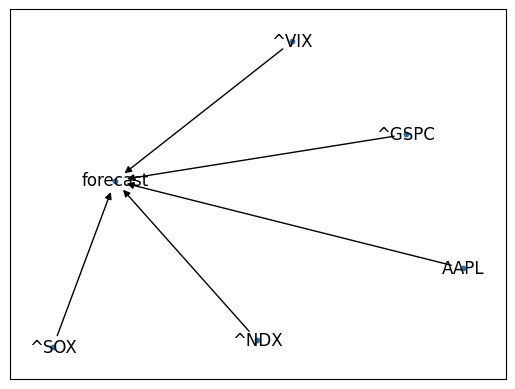

In [ ]:
########## Constructing sample knowledge graph of Belief Network #####
 
my_edges = []
for col in c_data.columns:
    if col == 'forecast':
        pass
    else:
        my_edges.append((col,'forecast'))

### Sample prior knowledge graph
print("possible edges will be:",my_edges)

##### Contructing Prior Graph Image using NetworkX ####
G=nx.DiGraph()
G.add_edges_from(my_edges)
label_dict = {}
for node in G.nodes():
    label_dict[node] = node
pos = nx.spring_layout(G);
nx.draw_networkx_nodes(G, pos, node_size = 10)
nx.draw_networkx_edges(G, pos, arrows=True)
nx.draw_networkx_labels(G,pos,labels=label_dict,)
plt.show()

  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned bayesian structure edges are:
 [('^GSPC', '^VIX'), ('^GSPC', '^SOX'), ('^NDX', '^GSPC'), ('^NDX', 'AAPL'), ('^NDX', '^SOX'), ('^SOX', 'AAPL')]


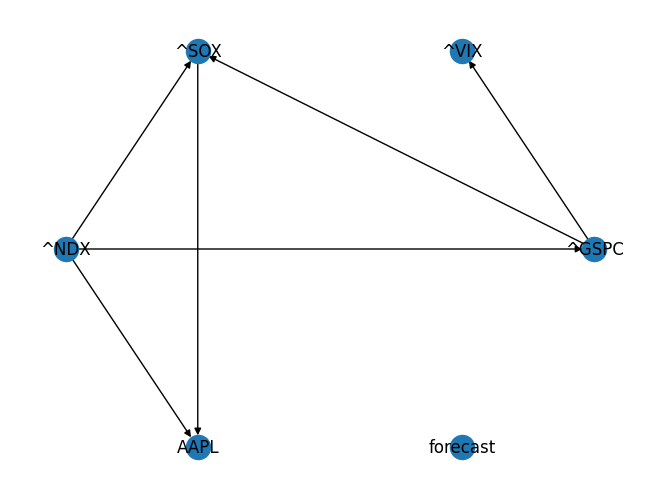

In [ ]:
############ Appliying hillclimb search to best Bayesian network ###########
################## If some prior structure is known ########################

edges = my_edges ## Feeding the prior knowledge graph

train_df = c_data.iloc[:,:] ### TRAINING WITH COMPLETE DATA 

model = BayesianNetwork()
model.add_nodes_from(nodes=list(train_df.columns))
model.add_edges_from(edges)

hc = HillClimbSearch(train_df,state_names=dict(map(lambda e: (e, [0, 1]), train_df),node_names=list(train_df.columns)))
k2 = K2Score(train_df)
learned_model = hc.estimate(start_dag=model,scoring_method=k2)

print("Learned bayesian structure edges are:\n",learned_model.edges())

##### Fitting the Data into Learned Model ###############
learned_model.fit(train_df,state_names=dict(map(lambda e: (e, [0, 1]), train_df.columns)),
                  estimator=BayesianEstimator, prior_type="K2")

######## Drawing the network ######################
# plt.figure(figsize=(14,6))
H=nx.DiGraph()
H.add_edges_from(learned_model.edges())
H.add_nodes_from(learned_model.nodes())
label_dict = {}
for node in H.nodes():
    label_dict[node] = node
pos = nx.spring_layout(H)
# nx.draw_networkx_nodes(H, pos, node_size = 10)
# nx.draw_networkx_edges(H, pos, arrows=True)
# nx.draw_networkx_labels(H,pos,labels=label_dict,)
nx.draw_circular(H,labels=label_dict,)
plt.show()

In [ ]:
H.edges()

OutEdgeView([('^GSPC', '^VIX'), ('^GSPC', '^SOX'), ('^SOX', 'AAPL'), ('^NDX', '^GSPC'), ('^NDX', 'AAPL'), ('^NDX', '^SOX')])

In [ ]:
print(mom)

NameError: name 'mom' is not defined

In [ ]:
### Optimal Belief Network Configurations #########

print('Nodes of the model:',learned_model.nodes())
print('Edges of the model:',learned_model.edges())

#### Printing CPD table of the dataset ###########
for model in learned_model.get_cpds():
    print("\n\nThe CPD table is:\n",model)


Nodes of the model: ['AAPL', '^GSPC', '^NDX', '^SOX', '^VIX', 'DCOILWTICO', 'forecast']
Edges of the model: [('AAPL', 'DCOILWTICO'), ('^GSPC', 'forecast'), ('^GSPC', '^NDX'), ('^GSPC', '^SOX'), ('^GSPC', 'AAPL'), ('^GSPC', 'DCOILWTICO'), ('^NDX', '^SOX'), ('^NDX', 'AAPL'), ('^SOX', 'AAPL'), ('^VIX', 'forecast'), ('^VIX', '^GSPC'), ('DCOILWTICO', 'forecast')]


The CPD table is:
 +---------+--------------------+-----+---------------------+
| ^GSPC   | ^GSPC(0)           | ... | ^GSPC(1)            |
+---------+--------------------+-----+---------------------+
| ^NDX    | ^NDX(0)            | ... | ^NDX(1)             |
+---------+--------------------+-----+---------------------+
| ^SOX    | ^SOX(0)            | ... | ^SOX(1)             |
+---------+--------------------+-----+---------------------+
| AAPL(0) | 0.7222222222222222 | ... | 0.21951219512195122 |
+---------+--------------------+-----+---------------------+
| AAPL(1) | 0.2777777777777778 | ... | 0.7804878048780488  |
+-------

In [ ]:
#### QuantumCircuit initialization ####
node_list = list(learned_model.nodes())
cr = ClassicalRegister(1,'signal')
qc= QuantumCircuit([]) #,cr)

for node in node_list:
    qc.add_register(QuantumRegister(1,node)) # Adding qubits with names same as nodes


data_qc = qc.copy()
model_qc = qc.copy()
######### Contructing the QBN from available CPD and ###### 
######### the Learned Belief Network Structure       #######
for i in range(len(learned_model.get_cpds())):
    my_model = learned_model.get_cpds()[i]
    print('\n\nModel state space:',my_model.state_names)



    if len(my_model.variables) == 1:
        cpd = pd.DataFrame(my_model.get_values(),columns=['Probs']).rename_axis(my_model.variable,axis=1)
        cpd['theta'] = 2*np.arctan(np.sqrt(cpd['Probs'].iloc[0]/cpd['Probs'].iloc[1]))
        print(cpd)

        data_qc.ry(prob_to_angle(my_model.values[1]),node_list.index(my_model.variable))
    else:
        print('Control:',my_model.variables[1:],'-----------> Target:',my_model.variable)

        lst = np.array(list(itertools.product([0, 1], repeat=len(my_model.variables)-1)))
        cpd = pd.DataFrame(np.array(lst),columns = my_model.variables[1:])
        cpd['Prob_'+ my_model.variable + str(0)] = my_model.get_values()[0,:]
        cpd['Prob_'+ my_model.variable + str(1)] = my_model.get_values()[1,:]
        cpd['theta'] = 2*np.arctan(np.sqrt(cpd['Prob_'+ my_model.variable + str(0)]/cpd['Prob_'+ my_model.variable + str(1)]))
        print(cpd)

        for j in range(cpd.shape[0]):
            ctrls = [str(int(z)) for z in cpd.iloc[j,:-3].values]
            ctrls = ''.join(ctrls)
            # print("The control state is",ctrls)
            model_qc = custom_mcry(model_qc,cpd.iloc[j,-1],[node_list.index(j) for j in my_model.variables[1:]],node_list.index(my_model.variable),ctrls)

    model_qc.barrier()

# qc.measure_all()
# qc.draw('mpl',fold=60)



Model state space: {'AAPL': [0, 1], '^GSPC': [0, 1], '^NDX': [0, 1], '^SOX': [0, 1]}
Control: ['^GSPC', '^NDX', '^SOX'] -----------> Target: AAPL
   ^GSPC  ^NDX  ^SOX  Prob_AAPL0  Prob_AAPL1     theta
0      0     0     0    0.722222    0.277778  2.031350
1      0     0     1    0.640000    0.360000  1.854590
2      0     1     0    0.666667    0.333333  1.910633
3      0     1     1    0.461538    0.538462  1.493797
4      1     0     0    0.850000    0.150000  2.346194
5      1     0     1    0.400000    0.600000  1.369438
6      1     1     0    0.285714    0.714286  1.127885
7      1     1     1    0.219512    0.780488  0.975232


Model state space: {'^GSPC': [0, 1], '^VIX': [0, 1]}
Control: ['^VIX'] -----------> Target: ^GSPC
   ^VIX  Prob_^GSPC0  Prob_^GSPC1     theta
0     0     0.154545     0.845455  0.808051
1     1     0.723404     0.276596  2.033991


Model state space: {'^NDX': [0, 1], '^GSPC': [0, 1]}
Control: ['^GSPC'] -----------> Target: ^NDX
   ^GSPC  Prob_^NDX0  Pro

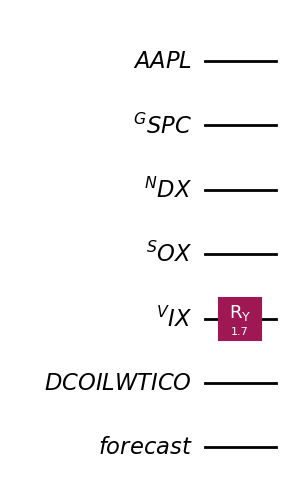

In [ ]:
data_qc.draw('mpl')

In [ ]:
print("Depth of the circuit is:",model_qc.depth())
print("2 qubit gate operations is:\n",model_qc.count_ops())
# model_qc.draw('mpl',fold=200)

Depth of the circuit is: 260
2 qubit gate operations is:
 OrderedDict([('cu', 112), ('cx', 104), ('x', 68), ('ry', 24), ('ccx', 16), ('barrier', 7)])


In [ ]:
#### Combine the circuit ##############33
qbn_qc = data_qc.compose(model_qc,qubits = range(model_qc.num_qubits))
qbn_qc.measure_all()
# qbn_qc.draw('mpl',fold=200)

In [ ]:
##### Running on simulator #####
backend = AerSimulator()

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qbn_qc)

print("Original Circuit depth is",qbn_qc.depth())
print("Transpiled Cicuit depth is",isa_circuit.depth())


with Session(service, backend = backend) as session:
    sampler = Sampler(session=session)

    job = sampler.run(qbn_qc, shots=1000)
    result = job.result()
    binary_data = result.quasi_dists[0].binary_probabilities()
    print(f"Job result: {binary_data}")

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02646 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1.38092 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('barrier', 7), ('ccx', 3)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mc

Original Circuit depth is 261
Transpiled Cicuit depth is 245


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.06606 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 6.38461 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'r

Job result: {'1000000': 0.002, '0010100': 0.001, '1100000': 0.001, '1100100': 0.004, '1011110': 0.001, '0000011': 0.001, '0111110': 0.001, '0101110': 0.001, '0111000': 0.005, '0001001': 0.006, '0010110': 0.004, '1000001': 0.005, '1101000': 0.003, '1010101': 0.009, '1011000': 0.001, '1110000': 0.002, '1001010': 0.001, '0000100': 0.003, '0100111': 0.004, '0110000': 0.003, '1101101': 0.002, '0110100': 0.007, '0011111': 0.005, '0000000': 0.001, '0011110': 0.003, '1001011': 0.01, '1111101': 0.011, '0000110': 0.001, '1110001': 0.002, '1111110': 0.003, '1100010': 0.003, '1010011': 0.017, '1010110': 0.007, '0010010': 0.012, '1001100': 0.011, '1011010': 0.016, '1110011': 0.025, '0110010': 0.003, '0011100': 0.005, '1111000': 0.004, '1001001': 0.018, '1001101': 0.056, '0101100': 0.025, '0001100': 0.001, '1100001': 0.001, '1101100': 0.003, '1010111': 0.016, '0101101': 0.043, '0010011': 0.034, '1011011': 0.032, '0011001': 0.004, '0101000': 0.014, '1111010': 0.01, '1000100': 0.006, '0111001': 0.005,

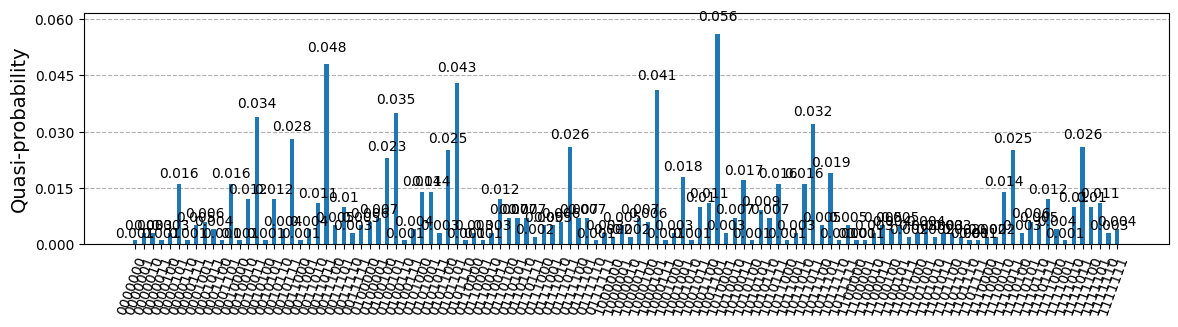

In [ ]:
######## Plotting the distribution #############
plot_histogram(binary_data,figsize=(14,3))

In [ ]:
q_data['forecast'] = data[target].apply(lambda x: 1 if x >= 0 else 0).shift(-1) #.apply(np.int64)
q_data.dropna(inplace=True)
q_data['forecast'] = q_data['forecast'].apply(np.int64)
q_data.head()

,AAPL,^GSPC,^NDX,^SOX,^VIX,DCOILWTICO,forecast
Date,,,,,,,
2019-01-03,1.776812,1.622408,1.640701,1.693980,1.379707,1.547232,1
2019-01-04,1.490679,1.504151,1.483681,1.487223,1.898627,1.537767,0
2019-01-07,1.580595,1.558851,1.553017,1.535821,1.571073,1.552220,1
2019-01-08,1.538011,1.553481,1.553834,1.584539,1.659978,1.519277,1
2019-01-09,1.542176,1.564676,1.558531,1.524288,1.620839,1.468114,1


In [ ]:
def encode_data(train_row): # Encoding angle data to quantum circuit Ry gates
    quantum_data = QuantumCircuit(train_row.shape[0],1)
    for j in range(len(train_row)):
        quantum_data.ry(train_row[j],j)

    quantum_data.barrier()
    return quantum_data


def Signal(result,price):
    info_dict = {0:-1,1:1}
    state = list(result.quasi_dists[0].keys())[0]
    diff = result.quasi_dists[0][1] - result.quasi_dists[0][0]
    if abs(diff) > 0.1:
        signal = info_dict[state]
        if signal == 1:  
            buy_price = price
            sell_price = np.nan
        elif signal == -1:
            buy_price = np.nan
            sell_price = price       
    else:
        signal = 0
        buy_price = np.nan
        sell_price = np.nan  
    return signal, buy_price, sell_price, state

In [ ]:
aer_sim = AerSimulator()
session = Session(backend=aer_sim)
options = Options()
options.execution.shots = 100
options.transpilation.skip_transpilation = True
options.optimization_level = 0
options.resilience_level = 0

all_signals = []
STATES = []
BUY_PRICE = []
SELL_PRICE = []

cr = ClassicalRegister(1)
model_qc.add_register(cr)


for i in range(q_data.shape[0]):
    price = data0.iloc[i+1,0]
    row = np.append(q_data.iloc[i,:-1].values,0)
    my_data = encode_data(row) #data.iloc[i,:].values)
    my_data.append(model_qc,qargs=range(q_data.iloc[i,:].values.shape[0]),cargs=[0])
    my_data.measure(-1,0)
    
    

    with Session(service, backend = backend) as session:
        sampler = Sampler(session=session)
        result = sampler.run(my_data,shots=100).result()
    # val_signal = list(result.quasi_dists[0].keys())[0]
    val_signal,buy_price, sell_price, state = Signal(result,price)
    all_signals.append(val_signal)
    BUY_PRICE.append(buy_price)
    SELL_PRICE.append(sell_price)
    STATES.append(state)
    print("The position of the next day is:",val_signal,result.quasi_dists[0])

/tmp/ipykernel_14007/619303498.py:28: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session)
base_primitive._run_primitive:INFO:2024-07-17 01:13:18,195: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.04983 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03409 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 32.42850 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: -1 {0: 0.45, 1: 0.55}


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.47922 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02170 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 193.64905 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:18,762: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevel

The position of the next day is: -1 {0: 0.43, 1: 0.57}


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.46780 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.81038 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.40770 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 16.86096 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.02799 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.59416 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.87023 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.39172 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 246.50431 (ms)
base_primitive._run_primitive:INFO:2024-

The position of the next day is: -1 {0: 0.45, 1: 0.55}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 13.61823 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.18487 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.74460 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.99659 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.05484 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 1.19019 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02623 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 200.94466 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:19,418: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: -1 {0: 0.41, 1: 0.59}
The position of the next day is: 0 {0: 0.46, 1: 0.54}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 19.12475 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 0 {0: 0.48, 1: 0.52}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 54.53229 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.17152 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 1.60408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.70620 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.39363 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 27.32706 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.46589 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 12.76851 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.66161 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.87142 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager

The position of the next day is: -1 {0: 0.42, 1: 0.58}
The position of the next day is: 0 {1: 0.52, 0: 0.48}


base_primitive._run_primitive:INFO:2024-07-17 01:13:20,464: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 18.13006 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.5, 0: 0.5}


base_primitive._run_primitive:INFO:2024-07-17 01:13:21,012: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02480 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01884 (ms)


The position of the next day is: 0 {1: 0.52, 0: 0.48}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 66.23745 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1', 'mcx_gray', 'u3'

The position of the next day is: -1 {0: 0.59, 1: 0.41}
The position of the next day is: 0 {0: 0.47, 1: 0.53}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01359 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 15.98167 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 0 {0: 0.51, 1: 0.49}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 63.44509 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 6.54364 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.68581 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.94621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.39411 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 37.07910 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.80340 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.40121 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.85926 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.39792 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.

The position of the next day is: -1 {0: 0.38, 1: 0.62}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 18.03946 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.48265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.38459 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.46119 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03338 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.28968 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02241 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 211.21621 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:22,517: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 1 {1: 0.55, 0: 0.45}


base_primitive._run_primitive:INFO:2024-07-17 01:13:22,737: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 15.90085 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.46, 0: 0.54}


base_primitive._run_primitive:INFO:2024-07-17 01:13:23,012: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03648 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03791 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 55.39083 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.46, 1: 0.54}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.003s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 23.18192 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.97919 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.42534 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 27.28152 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.87421 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.36711 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.10054 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.40770 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 39.687

The position of the next day is: 0 {1: 0.47, 0: 0.53}
The position of the next day is: -1 {0: 0.3, 1: 0.7}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 19.54579 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 0 {1: 0.47, 0: 0.53}


base_primitive._run_primitive:INFO:2024-07-17 01:13:24,106: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 26.21150 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: -1 {0: 0.55, 1: 0.45}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.003s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 18.27335 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.93293 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.40889 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 20.99490 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.05493 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.11153 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.01185 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.39387 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02646 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 18.403

The position of the next day is: 0 {0: 0.49, 1: 0.51}
The position of the next day is: 1 {1: 0.43, 0: 0.57}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 16.94274 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: -1 {0: 0.38, 1: 0.62}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 19.37103 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.85084 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.13902 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.70715 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.31018 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01788 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 230.11827 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:25,217: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 0 {0: 0.54, 1: 0.46}


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.61180 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.73791 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.48304 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 15.01131 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.98467 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.32165 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.05667 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.22745 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01645 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 204.74553 (ms)
base_primitive._run_primitive:INFO:2024-

The position of the next day is: 0 {1: 0.52, 0: 0.48}
The position of the next day is: 0 {1: 0.54, 0: 0.46}


base_primitive._run_primitive:INFO:2024-07-17 01:13:25,682: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 12.07781 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.49, 1: 0.51}


base_primitive._run_primitive:INFO:2024-07-17 01:13:26,142: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02551 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 62.10017 (ms)


The position of the next day is: 0 {1: 0.51, 0: 0.49}


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1', 'mcx_gray', 'u3', 'delay', 'mcp', 'p', 'switch_case', 'save_expval_var', 'save_amplitudes_sq

The position of the next day is: 1 {1: 0.59, 0: 0.41}
The position of the next day is: 0 {0: 0.47, 1: 0.53}


base_primitive._run_primitive:INFO:2024-07-17 01:13:26,751: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 24.72138 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.52, 1: 0.48}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 36.52620 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.69063 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 8.23259 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.84424 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.60534 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02766 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 244.74239 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:27,352: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 0 {1: 0.53, 0: 0.47}


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.49710 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 18.54157 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.76620 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.98493 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.85616 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.46039 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02694 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02599 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 204.79393 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:27,734: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpila

The position of the next day is: 1 {1: 0.58, 0: 0.42}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 16.46233 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.47622 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 2.60615 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.95201 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02670 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.40936 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02074 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 186.71322 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:27,995: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: -1 {0: 0.63, 1: 0.37}


base_primitive._run_primitive:INFO:2024-07-17 01:13:28,211: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 25.23088 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 1 {1: 0.43, 0: 0.57}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 60.86063 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.07806 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.94392 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.73681 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02599 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.35548 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 24.30177 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.53963 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.33898 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.96250 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.42176 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.

The position of the next day is: 0 {0: 0.5, 1: 0.5}


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 1.51515 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.58954 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.44942 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 192.30914 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:28,877: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02074 (ms)
I

The position of the next day is: -1 {0: 0.44, 1: 0.56}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 16.20269 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.61767 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.41940 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.79584 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03171 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.48018 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02384 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 193.16983 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:29,134: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 1 {1: 0.57, 0: 0.43}
The position of the next day is: -1 {0: 0.44, 1: 0.56}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03481 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 30.18498 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 0 {0: 0.51, 1: 0.49}
The position of the next day is: 0 {1: 0.46, 0: 0.54}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02694 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03004 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 18.81433 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 0 {1: 0.49, 0: 0.51}


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.79632 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.41389 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03147 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 198.42219 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:30,695: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02098

The position of the next day is: 0 {1: 0.53, 0: 0.47}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 36.55887 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.88351 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.17709 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.95320 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.67043 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 28.08452 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.85037 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.69096 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.17278 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.40221 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.

The position of the next day is: 0 {1: 0.51, 0: 0.49}
The position of the next day is: -1 {0: 0.43, 1: 0.57}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03648 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 17.89975 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 0 {1: 0.53, 0: 0.47}


base_primitive._run_primitive:INFO:2024-07-17 01:13:31,782: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02861 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 40.09271 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 1 {1: 0.56, 0: 0.44}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.013s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 37.29916 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.08110 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.46778 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 32.63044 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.68633 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.13616 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.24002 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.23317 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 16.594

The position of the next day is: 0 {1: 0.49, 0: 0.51}
The position of the next day is: -1 {0: 0.44, 1: 0.56}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 18.21828 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 0 {1: 0.49, 0: 0.51}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 59.67355 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.76740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.93543 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.77057 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.37789 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03052 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 232.48911 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:32,903: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 0 {1: 0.53, 0: 0.47}


INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 39.74223 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'meas

The position of the next day is: 0 {1: 0.52, 0: 0.48}


base_primitive._run_primitive:INFO:2024-07-17 01:13:33,553: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 19.82546 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: -1 {0: 0.41, 1: 0.59}


base_primitive._run_primitive:INFO:2024-07-17 01:13:33,802: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02670 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.03624 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 17.00282 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.53, 1: 0.47}


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.88765 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.58279 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.37932 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02193 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 214.89549 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:34,213: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02003 (ms)
I

The position of the next day is: 1 {1: 0.56, 0: 0.44}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 14.77790 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.93405 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.32594 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.40841 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.38743 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02575 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 199.39137 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:34,491: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 0 {1: 0.48, 0: 0.52}


base_primitive._run_primitive:INFO:2024-07-17 01:13:34,706: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 19.38677 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.49, 1: 0.51}


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.37026 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 186.98287 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:34,953: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03362 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevel

The position of the next day is: 0 {1: 0.52, 0: 0.48}


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.35930 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01836 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 197.16597 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:35,302: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevel

The position of the next day is: 0 {1: 0.48, 0: 0.52}


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02980 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.35191 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 40.59625 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.08998 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.02856 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.84209 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.42367 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 29.35553 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 6.93917 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.78370 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.17970 (ms)
INFO:qiskit.passmanager.

The position of the next day is: 0 {0: 0.46, 1: 0.54}


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 193.95065 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:35,945: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 18.90564 (ms)
INFO:qiskit.transpiler.passes.basis

The position of the next day is: -1 {0: 0.38, 1: 0.62}


base_primitive._run_primitive:INFO:2024-07-17 01:13:36,198: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 18.53490 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: -1 {0: 0.55, 1: 0.45}


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 25.26999 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.71406 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.39148 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 221.59195 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:36,518: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02050 (ms)


The position of the next day is: 0 {1: 0.53, 0: 0.47}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.006s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.002s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 25.66171 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 18.07141 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.34904 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02980 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 37.24647 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.83582 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.56786 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.43201 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02694 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.38362 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedP

The position of the next day is: 1 {1: 0.6, 0: 0.4}


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.87929 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.54336 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02050 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 199.91541 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:37,262: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02956 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02313

The position of the next day is: 0 {0: 0.46, 1: 0.54}


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02551 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.48232 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 35.29692 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.01893 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 6.99449 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 10.32424 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.39721 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 29.25539 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.74403 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.20022 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.94318 (ms)
INFO:qiskit.passmanager

The position of the next day is: 0 {0: 0.52, 1: 0.48}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02170 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 174.25632 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:37,959: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 16.50596 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2

The position of the next day is: -1 {0: 0.43, 1: 0.57}
The position of the next day is: 0 {1: 0.54, 0: 0.46}


base_primitive._run_primitive:INFO:2024-07-17 01:13:38,170: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 17.03811 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.53, 0: 0.47}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.82796 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.70908 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.76652 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.37789 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02003 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 194.80824 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:38,701: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
I

The position of the next day is: 0 {1: 0.5, 0: 0.5}


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1', 'mcx_gray', 'u3', 'delay', 'mcp', 'p', 'switch_case', 'save_expval_var', 'save_amplitudes_sq

The position of the next day is: 0 {1: 0.46, 0: 0.54}


base_primitive._run_primitive:INFO:2024-07-17 01:13:39,344: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 19.28520 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.51, 1: 0.49}


base_primitive._run_primitive:INFO:2024-07-17 01:13:39,587: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03648 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 23.77367 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 1 {1: 0.55, 0: 0.45}


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 2.77495 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.45657 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.37384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02098 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 187.62112 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:39,847: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01168 (ms)
I

The position of the next day is: 0 {0: 0.47, 1: 0.53}


base_primitive._run_primitive:INFO:2024-07-17 01:13:40,142: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 24.67585 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.48, 1: 0.52}


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.49832 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.68450 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.43011 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03147 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 192.90614 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:40,419: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01979 (ms)
I

The position of the next day is: -1 {0: 0.45, 1: 0.55}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.99580 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.81899 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.91076 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.42558 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02670 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 218.44029 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:40,739: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
I

The position of the next day is: 0 {1: 0.52, 0: 0.48}
The position of the next day is: 1 {1: 0.62, 0: 0.38}


base_primitive._run_primitive:INFO:2024-07-17 01:13:40,940: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 22.59707 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: -1 {0: 0.56, 1: 0.44}


base_primitive._run_primitive:INFO:2024-07-17 01:13:41,392: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02956 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 17.95411 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.48, 1: 0.52}
The position of the next day is: 1 {1: 0.55, 0: 0.45}


base_primitive._run_primitive:INFO:2024-07-17 01:13:41,610: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01335 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01168 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 16.52861 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.52, 1: 0.48}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 48.15578 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.87135 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.80278 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.89431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03338 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.33641 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03052 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 22.70317 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.96624 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 15.03897 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.92721 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.44441 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02170 (ms)
INFO:qiskit.passmanager

The position of the next day is: 0 {0: 0.52, 1: 0.48}


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 6.24347 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.94652 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.40174 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02241 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 180.63211 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:42,530: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01407 (ms)
I

The position of the next day is: 1 {1: 0.42, 0: 0.58}


base_primitive._run_primitive:INFO:2024-07-17 01:13:42,754: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.04840 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 16.31188 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.52, 1: 0.48}


base_primitive._run_primitive:INFO:2024-07-17 01:13:42,979: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 22.75157 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.54, 0: 0.46}


base_primitive._run_primitive:INFO:2024-07-17 01:13:43,197: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02646 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 16.35957 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.52, 0: 0.48}


base_primitive._run_primitive:INFO:2024-07-17 01:13:43,449: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.04458 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 17.42816 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: -1 {0: 0.34, 1: 0.66}


base_primitive._run_primitive:INFO:2024-07-17 01:13:43,693: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 16.12163 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.53, 0: 0.47}


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.21529 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.04959 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 184.61728 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:44,031: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01931 (ms)


The position of the next day is: -1 {0: 0.45, 1: 0.55}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 46.42200 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1', 'mcx_gray', 'u3'

The position of the next day is: 0 {1: 0.47, 0: 0.53}
The position of the next day is: -1 {0: 0.44, 1: 0.56}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.03314 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 32.96638 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 0 {1: 0.49, 0: 0.51}


base_primitive._run_primitive:INFO:2024-07-17 01:13:45,149: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.09155 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 22.41087 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.52, 0: 0.48}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.88033 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.18329 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.40722 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.19312 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02384 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 194.47708 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:45,394: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
I

The position of the next day is: 0 {0: 0.48, 1: 0.52}


base_primitive._run_primitive:INFO:2024-07-17 01:13:45,658: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02742 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 43.20073 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.47, 1: 0.53}


INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 22.22896 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.03283 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.46420 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 57.88946 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.83558 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.10438 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.73576 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.37861 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 43.08963 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.79474 (ms)
INFO:qiskit.passmana

The position of the next day is: -1 {0: 0.45, 1: 0.55}


base_primitive._run_primitive:INFO:2024-07-17 01:13:46,393: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 14.67943 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: -1 {0: 0.45, 1: 0.55}


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.94652 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01359 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.40340 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02861 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 191.58864 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:46,638: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01240 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01550

The position of the next day is: 0 {0: 0.54, 1: 0.46}


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.43416 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02050 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 197.17884 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:46,969: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01979 (ms)


The position of the next day is: -1 {0: 0.39, 1: 0.61}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 39.14070 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1', 'mcx_gray', 'u3'

The position of the next day is: 0 {1: 0.49, 0: 0.51}


base_primitive._run_primitive:INFO:2024-07-17 01:13:47,587: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01216 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01192 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 14.77933 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.48, 0: 0.52}
The position of the next day is: 1 {1: 0.6, 0: 0.4}


base_primitive._run_primitive:INFO:2024-07-17 01:13:47,794: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 16.56938 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: -1 {0: 0.43, 1: 0.57}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.66011 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 9.20463 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.93842 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.39721 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02003 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 209.59640 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:48,374: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
I

The position of the next day is: 0 {1: 0.48, 0: 0.52}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 48.88082 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1', 'mcx_gray', 'u3'

The position of the next day is: 0 {1: 0.52, 0: 0.48}
The position of the next day is: 0 {0: 0.47, 1: 0.53}


base_primitive._run_primitive:INFO:2024-07-17 01:13:48,940: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02694 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 25.81573 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.46, 0: 0.54}


INFO:qiskit.compiler.transpiler:Total Transpile Time - 186.32174 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:49,491: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.04220 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 17.98272 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7

The position of the next day is: -1 {0: 0.43, 1: 0.57}
The position of the next day is: 0 {1: 0.5, 0: 0.5}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 16.34860 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 0 {0: 0.46, 1: 0.54}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 23.34762 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.43115 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.35281 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.42582 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.31328 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 20.40792 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.39332 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.70240 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.85640 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.36168 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.

The position of the next day is: -1 {0: 0.43, 1: 0.57}


base_primitive._run_primitive:INFO:2024-07-17 01:13:50,613: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 19.55414 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.47, 0: 0.53}
The position of the next day is: 0 {1: 0.52, 0: 0.48}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 19.82880 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 0 {0: 0.48, 1: 0.52}


base_primitive._run_primitive:INFO:2024-07-17 01:13:51,244: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03624 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 14.76264 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.54, 0: 0.46}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 18.23354 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.20299 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 2.27952 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.96560 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.38004 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02074 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 204.70452 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:51,525: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 0 {0: 0.46, 1: 0.54}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 37.44221 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.90806 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 11.36184 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.81658 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.48208 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 44.49368 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.51222 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 9.15790 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.58615 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.40889 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager

The position of the next day is: 0 {1: 0.52, 0: 0.48}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 34.37018 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.93246 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 1.68991 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.91553 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.38981 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 19.33646 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.94430 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 2.98095 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.07813 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.43488 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.

The position of the next day is: -1 {0: 0.55, 1: 0.45}


base_primitive._run_primitive:INFO:2024-07-17 01:13:52,582: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 17.76481 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: -1 {0: 0.57, 1: 0.43}


base_primitive._run_primitive:INFO:2024-07-17 01:13:52,805: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 26.39985 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.54, 0: 0.46}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 25.00224 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.19560 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.84212 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.89955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.41342 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.05078 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02170 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 230.14498 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:53,147: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 0 {0: 0.54, 1: 0.46}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 58.37774 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.90973 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 8.35896 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.32515 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.47493 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 57.23357 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.91927 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.80754 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.91243 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.53000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.

The position of the next day is: 0 {1: 0.51, 0: 0.49}


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.42820 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.31638 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03242 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 184.92723 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:53,865: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02623

The position of the next day is: -1 {0: 0.44, 1: 0.56}


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03338 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01764 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 193.50004 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:54,144: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02813 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 16.47329 (ms)
INFO:qiskit.transpiler.passes.basis

The position of the next day is: 1 {1: 0.42, 0: 0.58}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02313 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 187.90507 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:54,423: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 23.49520 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2

The position of the next day is: 0 {1: 0.5, 0: 0.5}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 16.80756 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 5.33724 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.07355 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.24638 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.32759 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01717 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 202.78788 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:54,800: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 0 {1: 0.51, 0: 0.49}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 22.32742 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.03824 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.56293 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.54765 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.18382 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02241 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 205.36113 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:55,089: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 1 {1: 0.58, 0: 0.42}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02050 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 184.58414 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:55,354: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02742 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 22.15147 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2

The position of the next day is: 1 {1: 0.55, 0: 0.45}


INFO:qiskit.compiler.transpiler:Total Transpile Time - 193.89057 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:55,598: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01359 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 21.38782 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7

The position of the next day is: 0 {0: 0.46, 1: 0.54}


base_primitive._run_primitive:INFO:2024-07-17 01:13:55,819: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 38.57374 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.51, 0: 0.49}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 29.52433 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.99461 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.16486 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.86784 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.53573 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 52.81377 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.88351 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 16.04152 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.00660 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 1.93930 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager

The position of the next day is: 0 {0: 0.46, 1: 0.54}


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.14467 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.84615 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02551 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.38362 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 28.91564 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.71542 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 2.88939 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.85187 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.33426 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.04220 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01812 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 205.86634 (ms)
base_primitive._run_primitive:INFO:2024-

The position of the next day is: 0 {0: 0.46, 1: 0.54}


base_primitive._run_primitive:INFO:2024-07-17 01:13:56,839: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01240 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 14.64748 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.51, 0: 0.49}


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.36550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01550 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 172.22834 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:57,085: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03028 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevel

The position of the next day is: 0 {0: 0.51, 1: 0.49}


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02980 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 191.58316 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:57,341: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 44.17753 (ms)
INFO:qiskit.transpiler.passes.basis

The position of the next day is: -1 {0: 0.38, 1: 0.62}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 48.16723 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.78075 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.17852 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.93031 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.38290 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02408 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 244.96055 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:57,715: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: -1 {0: 0.41, 1: 0.59}


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.91672 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.39029 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 30.45559 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.63906 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 2.56848 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.89812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.38981 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 12.86483 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.93620 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 2.89130 (ms)
INFO:qiskit.passmanager.

The position of the next day is: 0 {0: 0.48, 1: 0.52}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02837 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 25.07687 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 0 {0: 0.52, 1: 0.48}


base_primitive._run_primitive:INFO:2024-07-17 01:13:58,880: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 15.23280 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.53, 0: 0.47}


base_primitive._run_primitive:INFO:2024-07-17 01:13:59,103: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01311 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 21.14582 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 1 {1: 0.58, 0: 0.42}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 41.52560 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.93024 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.30520 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.80085 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.31447 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02432 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 230.48496 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:13:59,412: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 1 {1: 0.56, 0: 0.44}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 39.38508 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.05064 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.59464 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.41470 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.39244 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 20.96725 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.81930 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.81947 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.95081 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.64921 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.

The position of the next day is: 0 {0: 0.54, 1: 0.46}
The position of the next day is: 1 {1: 0.62, 0: 0.38}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 19.90700 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 0 {0: 0.51, 1: 0.49}


base_primitive._run_primitive:INFO:2024-07-17 01:14:00,468: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02623 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 41.59522 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 1 {1: 0.42, 0: 0.58}


INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 29.57821 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.92387 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.41628 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02885 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 23.83137 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.72734 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.99780 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.87214 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.42653 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 27.67467 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.05667 (ms)
INFO:qiskit.passmana

The position of the next day is: -1 {0: 0.39, 1: 0.61}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 13.88049 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.82319 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 2.98572 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.69571 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.44513 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.05984 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03028 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 194.91386 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:01,148: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 1 {1: 0.57, 0: 0.43}


base_primitive._run_primitive:INFO:2024-07-17 01:14:01,376: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 21.28768 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.49, 1: 0.51}


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.32806 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03815 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 198.35806 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:01,758: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03624 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01884 (ms)


The position of the next day is: 0 {1: 0.48, 0: 0.52}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 73.65108 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1', 'mcx_gray', 'u3'

The position of the next day is: 0 {0: 0.51, 1: 0.49}


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.40388 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 16.83116 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.33364 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.48680 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.07574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.43201 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02456 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 219.67554 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:02,558: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience':

The position of the next day is: 0 {1: 0.51, 0: 0.49}


base_primitive._run_primitive:INFO:2024-07-17 01:14:02,791: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03910 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 19.37079 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.47, 0: 0.53}


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.73743 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.45419 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 211.17496 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:03,047: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01740

The position of the next day is: 1 {1: 0.56, 0: 0.44}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.77734 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 7.40790 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.93079 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.47970 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 212.57997 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:03,391: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
I

The position of the next day is: 1 {1: 0.64, 0: 0.36}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 35.73656 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.02990 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.01020 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.84767 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.48852 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 19.33837 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.92070 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.70622 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.96750 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.41318 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02861 (ms)
INFO:qiskit.passmanager.

The position of the next day is: 0 {1: 0.52, 0: 0.48}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.60503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.34001 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.74117 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.32210 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.04315 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 211.79843 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:04,006: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
I

The position of the next day is: 1 {1: 0.58, 0: 0.42}


base_primitive._run_primitive:INFO:2024-07-17 01:14:04,221: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03147 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 16.79969 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.52, 0: 0.48}


base_primitive._run_primitive:INFO:2024-07-17 01:14:04,447: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 17.87019 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: -1 {0: 0.56, 1: 0.44}


base_primitive._run_primitive:INFO:2024-07-17 01:14:04,668: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02980 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 19.93275 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.48, 0: 0.52}


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.42248 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.04268 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 55.86314 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.80840 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 10.68258 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.76485 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.40293 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02265 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 296.27609 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:05,113: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience'

The position of the next day is: 1 {1: 0.44, 0: 0.56}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 17.04860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.95146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.11422 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.93675 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.54431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02575 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 166.57829 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:05,370: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 0 {1: 0.5, 0: 0.5}
The position of the next day is: 0 {0: 0.48, 1: 0.52}


base_primitive._run_primitive:INFO:2024-07-17 01:14:05,581: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.04530 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 21.90924 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.53, 0: 0.47}


base_primitive._run_primitive:INFO:2024-07-17 01:14:06,016: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01216 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 20.43700 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.46, 1: 0.54}


base_primitive._run_primitive:INFO:2024-07-17 01:14:06,228: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02718 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 19.97304 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: -1 {0: 0.41, 1: 0.59}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 43.50066 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.79911 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.06082 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.94771 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.07772 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.39887 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 227.44775 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:06,591: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 1 {1: 0.55, 0: 0.45}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 35.29119 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.34914 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.32062 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.89931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.54193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.28324 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 22.20917 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.20132 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.47989 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.13170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.18334 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.26536 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01383 (ms)
INFO:qiskit.passmanager.

The position of the next day is: 0 {0: 0.49, 1: 0.51}


base_primitive._run_primitive:INFO:2024-07-17 01:14:07,155: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02694 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 17.91430 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: -1 {0: 0.41, 1: 0.59}
The position of the next day is: 0 {0: 0.51, 1: 0.49}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 27.18973 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 0 {1: 0.54, 0: 0.46}


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.41604 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 18.05043 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.94716 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.90887 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.81801 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.42319 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02003 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 206.65026 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:08,003: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience':

The position of the next day is: 0 {0: 0.48, 1: 0.52}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 12.48240 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.79291 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.47590 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.98228 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.45180 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02265 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 203.40276 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:08,268: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: -1 {0: 0.45, 1: 0.55}
The position of the next day is: 0 {1: 0.49, 0: 0.51}


base_primitive._run_primitive:INFO:2024-07-17 01:14:08,468: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 16.37220 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.47, 1: 0.53}


base_primitive._run_primitive:INFO:2024-07-17 01:14:09,044: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02980 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 42.36507 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.48, 0: 0.52}


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.41366 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 27.77004 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.79052 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.20682 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.76699 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.07963 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.41580 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 13.27181 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.92435 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.78752 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.98825 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.

The position of the next day is: 0 {0: 0.52, 1: 0.48}
The position of the next day is: 1 {1: 0.44, 0: 0.56}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01192 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 26.38388 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: -1 {0: 0.4, 1: 0.6}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.76311 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.80969 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.83423 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.50879 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02241 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 214.50925 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:10,123: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
I

The position of the next day is: 0 {0: 0.51, 1: 0.49}


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.88408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.72527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.33402 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02003 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 191.63489 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:10,425: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02003 (ms)
I

The position of the next day is: 0 {1: 0.47, 0: 0.53}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.39913 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 34.29103 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.86355 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.43607 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 44.16490 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.84178 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.84498 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.90027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.75841 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02265 (ms)
INFO:qiskit.compiler.transpiler:T

The position of the next day is: 0 {0: 0.52, 1: 0.48}


base_primitive._run_primitive:INFO:2024-07-17 01:14:11,135: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 16.15644 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.48, 1: 0.52}


base_primitive._run_primitive:INFO:2024-07-17 01:14:11,355: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02670 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 33.05578 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: -1 {0: 0.41, 1: 0.59}


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 31.65603 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.82128 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.58438 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.86498 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.33331 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02003 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 254.28510 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:11,756: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': Tru

The position of the next day is: 1 {1: 0.6, 0: 0.4}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 65.72461 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.72734 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.60966 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.92411 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02861 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.40174 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03362 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 20.15805 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.98586 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.66149 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.75579 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01359 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.54979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.

The position of the next day is: 0 {0: 0.51, 1: 0.49}
The position of the next day is: 0 {0: 0.46, 1: 0.54}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 21.52920 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 1 {1: 0.56, 0: 0.44}
The position of the next day is: -1 {0: 0.43, 1: 0.57}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02694 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 36.10849 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 1 {1: 0.6, 0: 0.4}


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 15.54465 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.88477 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.26490 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.80562 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.43321 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 16.63780 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.37918 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 2.24805 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.90742 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.52857 (ms)
INFO:qiskit.passmanager.

The position of the next day is: 0 {0: 0.53, 1: 0.47}
The position of the next day is: 0 {1: 0.47, 0: 0.53}


base_primitive._run_primitive:INFO:2024-07-17 01:14:13,708: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 16.38222 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: -1 {0: 0.43, 1: 0.57}


INFO:qiskit.compiler.transpiler:Total Transpile Time - 187.10232 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:14,253: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 32.08518 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7

The position of the next day is: -1 {0: 0.44, 1: 0.56}


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.89264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.55599 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.44894 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 19.15669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.85282 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 6.59394 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.96107 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.35262 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02050 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 262.32815 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:14,601: Submitting job using options {'optimization_level

The position of the next day is: 0 {1: 0.52, 0: 0.48}
The position of the next day is: -1 {0: 0.42, 1: 0.58}


base_primitive._run_primitive:INFO:2024-07-17 01:14:14,809: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01311 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02933 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 19.68503 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.46, 1: 0.54}
The position of the next day is: 0 {0: 0.51, 1: 0.49}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 20.83635 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: -1 {0: 0.43, 1: 0.57}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.286s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.001s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 295.79616 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.66566 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.42224 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02551 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 20.44487 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.89042 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.19116 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.00541 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.37384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedP

The position of the next day is: -1 {0: 0.41, 1: 0.59}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 79.35238 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1', 'mcx_gray', 'u3'

The position of the next day is: 0 {1: 0.47, 0: 0.53}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02098 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 196.35439 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:16,777: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 26.65329 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2

The position of the next day is: -1 {0: 0.44, 1: 0.56}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 23.43726 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.11167 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.64089 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.04308 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.47493 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02289 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 219.90085 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:17,085: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 0 {1: 0.52, 0: 0.48}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.06542 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 9.29594 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.92554 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.42200 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02146 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 217.17501 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:17,446: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
I

The position of the next day is: 0 {1: 0.52, 0: 0.48}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 41.21423 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 

The position of the next day is: 1 {1: 0.56, 0: 0.44}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.94168 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.07863 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.73552 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.41771 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 11.28101 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.87683 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.74484 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.00303 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.35143 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02050 (ms)
INFO:qiskit.compiler.transpiler:To

The position of the next day is: -1 {0: 0.44, 1: 0.56}


INFO:qiskit.compiler.transpiler:Total Transpile Time - 167.71221 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:18,524: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03052 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.06008 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 20.90478 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7

The position of the next day is: 0 {0: 0.49, 1: 0.51}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.90878 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.46565 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.79679 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.40126 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 183.67434 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:18,793: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
I

The position of the next day is: -1 {0: 0.42, 1: 0.58}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 71.85340 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1', 'mcx_gray', 'u3'

The position of the next day is: 0 {1: 0.5, 0: 0.5}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 52.03247 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.06320 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 6.21080 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.04189 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.41294 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 291.04853 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:19,727: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 0 {1: 0.5, 0: 0.5}


base_primitive._run_primitive:INFO:2024-07-17 01:14:19,995: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03672 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02813 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 29.57487 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.47, 1: 0.53}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.74284 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.56555 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.85235 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.36788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 16.81495 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.83058 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.59941 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.99087 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03242 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.38290 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.compiler.transpiler:To

The position of the next day is: 0 {0: 0.48, 1: 0.52}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02623 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 55.64094 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 1 {1: 0.57, 0: 0.43}


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.43654 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 18.70012 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 5.62906 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.53146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.89335 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.39482 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02694 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 246.24515 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:21,250: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience':

The position of the next day is: 0 {1: 0.51, 0: 0.49}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 32.28331 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.11549 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.77846 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.17016 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.40483 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 237.80274 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:21,585: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 0 {0: 0.46, 1: 0.54}


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.58129 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.80442 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.37837 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02098 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 200.55580 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:21,949: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01907 (ms)
I

The position of the next day is: 0 {1: 0.49, 0: 0.51}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 34.97815 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1', 'mcx_gray', 'u3'

The position of the next day is: -1 {0: 0.37, 1: 0.63}
The position of the next day is: 0 {1: 0.53, 0: 0.47}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02670 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.03338 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 22.00055 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 1 {1: 0.58, 0: 0.42}


INFO:qiskit.compiler.transpiler:Total Transpile Time - 170.13597 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:23,156: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01621 (ms)


The position of the next day is: 0 {1: 0.54, 0: 0.46}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 47.26052 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1', 'mcx_gray', 'u3'

The position of the next day is: 0 {1: 0.52, 0: 0.48}


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03576 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 200.14977 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:24,072: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 23.92077 (ms)
INFO:qiskit.transpiler.passes.basis

The position of the next day is: 1 {1: 0.59, 0: 0.41}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 36.19194 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.09427 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.11320 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.10698 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.44036 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01979 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 249.33004 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:24,423: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: 0 {1: 0.51, 0: 0.49}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 40.33852 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.60210 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 6.86502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.90575 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.40078 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02623 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 245.79668 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:24,793: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

The position of the next day is: -1 {0: 0.45, 1: 0.55}


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1', 'mcx_gray', 'u3', 'delay', 'mcp', 'p', 'switch_case', 'save_expval_var', 'save_amplitudes_sq

The position of the next day is: 0 {1: 0.51, 0: 0.49}
The position of the next day is: 1 {1: 0.55, 0: 0.45}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02480 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 13.73410 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 0 {1: 0.54, 0: 0.46}
The position of the next day is: 1 {1: 0.44, 0: 0.56}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 20.31803 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: -1 {0: 0.43, 1: 0.57}


INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 24.44768 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.65749 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.44632 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 30.96247 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.48432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 2.76017 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.76079 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.32353 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 21.53945 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.06757 (ms)
INFO:qiskit.passmana

The position of the next day is: 1 {1: 0.59, 0: 0.41}
The position of the next day is: 0 {0: 0.5, 1: 0.5}


base_primitive._run_primitive:INFO:2024-07-17 01:14:26,747: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03028 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 16.35480 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: -1 {0: 0.42, 1: 0.58}


base_primitive._run_primitive:INFO:2024-07-17 01:14:27,232: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03719 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)


The position of the next day is: 1 {1: 0.45, 0: 0.55}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 41.00370 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1', 'mcx_gray', 'u3'

The position of the next day is: -1 {0: 0.38, 1: 0.62}
The position of the next day is: 0 {1: 0.53, 0: 0.47}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02718 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 21.54469 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: 0 {0: 0.51, 1: 0.49}


base_primitive._run_primitive:INFO:2024-07-17 01:14:28,327: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03433 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 33.20622 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {1: 0.54, 0: 0.46}


INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 30.45177 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.00279 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.41986 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 31.02207 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.82390 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 3.52645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.84019 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.38195 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 20.38407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.92833 (ms)
INFO:qiskit.passmana

The position of the next day is: -1 {0: 0.44, 1: 0.56}


base_primitive._run_primitive:INFO:2024-07-17 01:14:28,926: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01240 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 16.10827 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.49, 1: 0.51}
The position of the next day is: -1 {0: 0.45, 1: 0.55}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03433 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 19.76991 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', '

The position of the next day is: -1 {0: 0.55, 1: 0.45}


base_primitive._run_primitive:INFO:2024-07-17 01:14:29,608: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 29.33049 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: -1 {0: 0.4, 1: 0.6}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 32.45115 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.83439 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.08244 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.76485 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.47493 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 22.62521 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.30384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.01513 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.99707 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.50545 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.

The position of the next day is: -1 {0: 0.43, 1: 0.57}


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.24819 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03076 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02360 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 175.94028 (ms)
base_primitive._run_primitive:INFO:2024-07-17 01:14:30,237: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevel

The position of the next day is: -1 {0: 0.43, 1: 0.57}


base_primitive._run_primitive:INFO:2024-07-17 01:14:30,445: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02885 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 16.75177 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('cx', 2), ('ry', 1), ('x', 1), ('barrier', 7)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', '

The position of the next day is: 0 {0: 0.48, 1: 0.52}
The position of the next day is: 0 {0: 0.47, 1: 0.53}


In [ ]:
print("Signals:",np.array(all_signals))
print("States :",np.array(STATES))
print("Forecast:",q_data.iloc[:,-1].values)

Signals: [-1 -1 -1 -1  0  0 -1  0  0  0 -1  0  0 -1  1  0  0  0 -1  0 -1  0  1 -1
  0  0  0  0  0  1  0  0  0  1 -1  1  0 -1  1 -1  0  0  0  0  0 -1  0  1
  0 -1  0  0  0 -1  0  1  0  0  0  0  0 -1 -1  0  1  0  0 -1  0  0  0  0
  0  1  0  0 -1  0  1 -1  0  1  0  0  1  0  0  0 -1  0 -1  0 -1  0  0  0
  0 -1 -1  0 -1  0  0  1 -1  0  0  0  0 -1  0  0 -1  0  0  0  0  0  0 -1
 -1  0  0  0 -1  1  0  0  1  1  0  0  0  0  0  0 -1 -1  0  0  0  1  1  0
  1  0  1 -1  1  0  0  0  0  0  1  1  0  1  0 -1  0  1  0  0  0  0 -1  1
  0 -1  0  0  0 -1  0  0  0  0  1 -1  0  0  0  0 -1  1  0  0  1 -1  1  0
  0 -1 -1  0 -1  0  0 -1 -1  0 -1  0  0  1 -1  0 -1  0  0  0  0  1  0  0
  0 -1  0  1  0  0  1  0 -1  0  1  0  1 -1  1  0 -1  1 -1  0  0  0 -1  0
 -1 -1 -1 -1 -1  0  0]
States : [0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0
 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1
 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1
 0 0

In [ ]:
len(STATES)

247

In [ ]:
all_trades = []
b_price = []
s_price = []
for i in range(1,len(STATES)):
    if STATES[i] > STATES[i-1]:
        all_trades.append(+1)
        b_price.append(data0.iloc[i,0])
        s_price.append(np.nan)
    elif STATES[i] < STATES[i-1]:
        all_trades.append(-1)
        b_price.append(np.nan)
        s_price.append(data0.iloc[i,0])
    else:
        all_trades.append(0)
        b_price.append(np.nan)
        s_price.append(np.nan)

print(np.array(all_trades))


[ 0  0  0  0  0  0  1  0  0 -1  0  0  0  1  0 -1  1 -1  1 -1  0  1 -1  0
  1  0 -1  1  0 -1  0  1  0 -1  1 -1  0  1 -1  0  1  0  0  0 -1  1  0  0
 -1  1  0  0 -1  0  1  0 -1  1  0 -1  0  0  1  0 -1  0  0  1  0  0  0 -1
  1 -1  0  0  1  0 -1  0  1 -1  0  1 -1  1  0 -1  1 -1  1 -1  1  0 -1  0
  0  0  0  0  1  0  0 -1  1  0 -1  1 -1  1 -1  0  1  0 -1  1 -1  1 -1  0
  1 -1  1 -1  1  0  0  0  0 -1  1 -1  0  1 -1  0  0  0  0  1  0  0 -1  1
 -1  1 -1  1 -1  1 -1  1  0  0  0  0  0  0 -1  1  0  0 -1  1 -1  0  1 -1
  0  0  1 -1  0  1 -1  1 -1  1 -1  0  1 -1  0  0  1 -1  0  1 -1  1 -1  1
 -1  0  1 -1  0  0  0  0  1 -1  1  0  0 -1  0  0  1  0 -1  0  1  0 -1  1
 -1  1  0  0  0  0  0 -1  1  0  0  0 -1  1 -1  0  1 -1  1 -1  1 -1  0  0
  0  0  0  0  0  0]


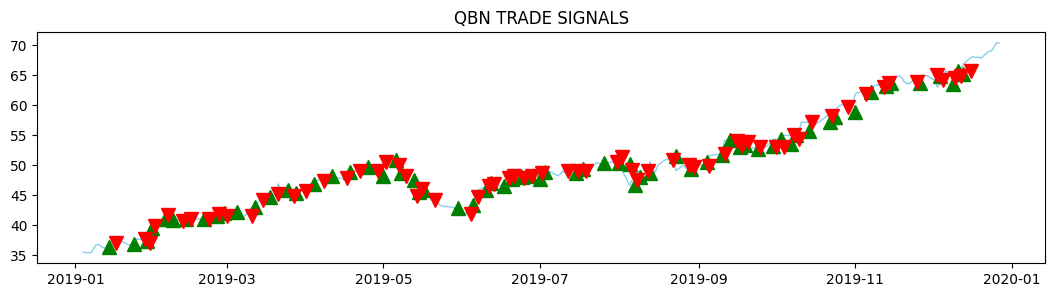

In [ ]:
stock_prices = data0.loc[q_data.index].iloc[1:,0]

plt.figure(figsize=(13,3))
plt.plot(stock_prices, linewidth =1, color = 'skyblue', label = target)
plt.plot(stock_prices.index, b_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
plt.plot(stock_prices.index, s_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
plt.title('QBN TRADE SIGNALS')
plt.show()

/home/aniruddha/miniconda3/envs/capstone_env1/lib/python3.10/site-packages/pyfolio/plotting.py:650: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-4.3%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100,


Start date,2019-01-04
End date,2019-12-27
Total months,11
,Backtest
Annual return,-4.3%
Cumulative returns,-4.2%
Annual volatility,29.7%
Sharpe ratio,0.00
Calmar ratio,-0.39
Stability,0.50
Max drawdown,-11.1%


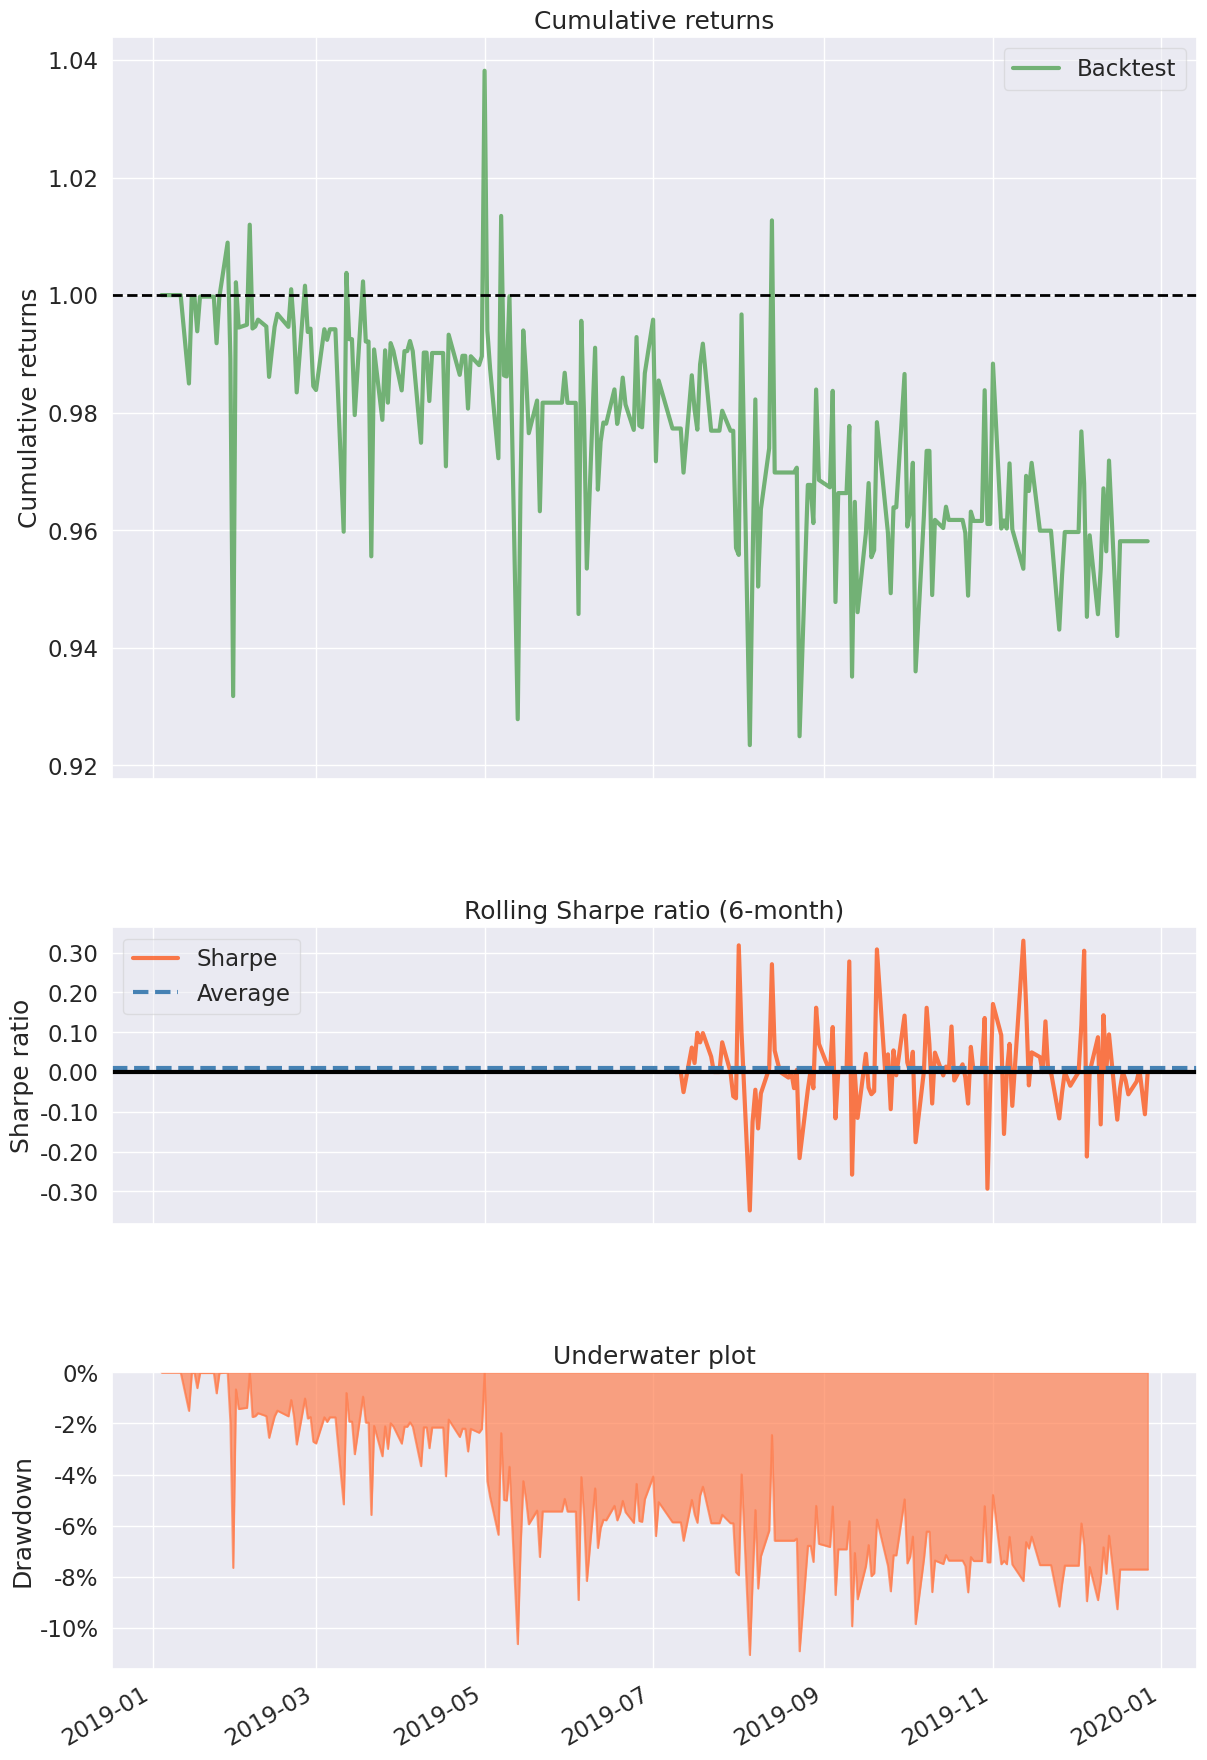

In [ ]:
strategy_returns = data.loc[q_data.index].iloc[1:,0]*np.array(all_trades)
pf.create_simple_tear_sheet(strategy_returns.diff())

<Axes: xlabel='Date'>

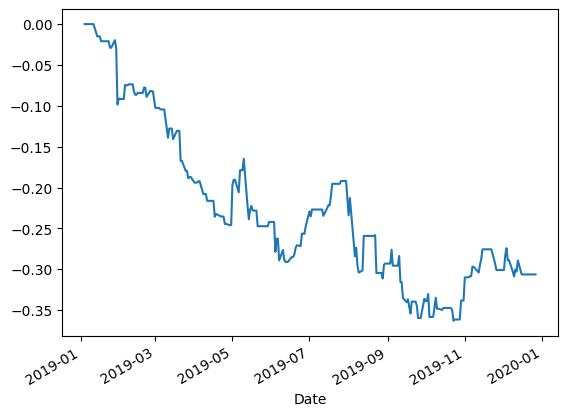

In [ ]:
strategy_returns.cumsum().plot()